In [2]:
import pandas as pd 
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm 
import seaborn as sns

In [3]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

In [ ]:
#MVP path merged = pd.read_csv("/shared/3/projects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")

In [ ]:
merged = merged.dropna(subset=["clustNum"])

In [ ]:
merged.shape

In [11]:
merged.head(1)

Unnamed: 0  key                                           local_id  \
0           0    0  andalusiastarnews--2020-04-04--Remember When: ...   

                           sourcedomain_id        date  \
0  andalusiastarnews-andalusiastarnews.com  2020-04-04   

                                 title  \
0  Remember When: Shehan’s Polio story   

                                             content  \
0  Dan Shehan’s “My Polio Story” is continued in ...   

                                                 url    fips  \
0  https://www.andalusiastarnews.com/2020/04/03/r...  1039.0   

              source  ... predrt_12 predrt_3 national   id author  published  \
0  andalusiastarnews  ...     44.15     30.8    False  NaN    NaN        NaN   

   published_utc collection_utc  year clustNum  
0            NaN            NaN  2020      NaN  

[1 rows x 46 columns]

In [100]:
#look at which outlet first started a story 

#first make sure we have the date of an outlet correctly specified 
merged["date"] = pd.to_datetime(merged["date"])

#group data together 
grouped = merged[["key", "source", "title", "content", "clustNum", "date", "national"]].groupby(by="clustNum").agg(list)
grouped["clustLen"] = grouped["key"].apply(len)

#get first to publish within a cluster 
grouped["first"] = grouped["date"].apply(lambda x: x.index(min(x)))

## Outlet level Stats

(0.0, 4000.0)

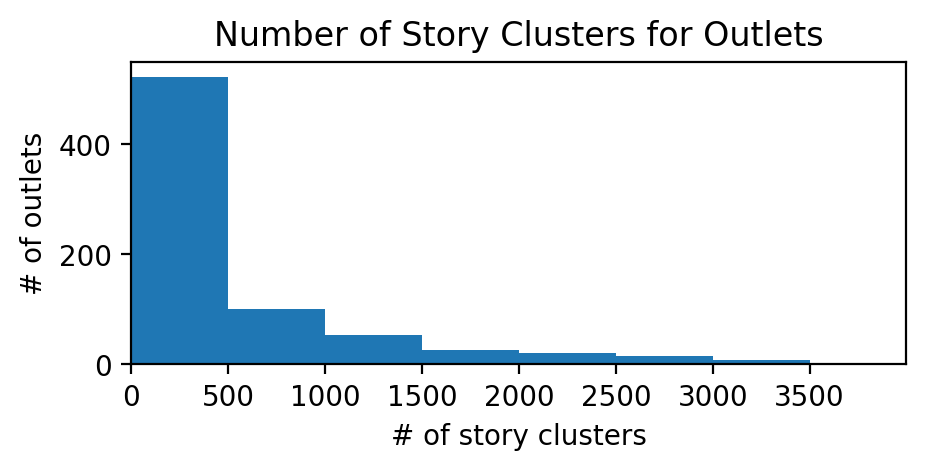

In [118]:
fig, axs = plt.subplots(figsize=(5, 2))
outletClustDf = merged[["source", "clustNum"]].groupby("source").agg(lambda x: len(set(x)))
plt.hist(outletClustDf["clustNum"], bins=np.arange(0, 4000, 500))
plt.title("Number of Story Clusters for Outlets")
plt.xlabel("# of story clusters")
plt.ylabel("# of outlets")
plt.xticks(np.arange(0, 4000, 500))
plt.xlim(0, 4000)

In [127]:
topOutlets = outletClustDf.sort_values("clustNum", ascending=False).iloc[:20, ].reset_index()


In [128]:
topOutlets

source  clustNum
0                    usnews     19639
1            theindependent     15273
2        whatreallyhappened     13483
3                    thesun     12058
4          therussophileorg     10542
5           eveningstandard      9786
6           theseattletimes      9339
7             theguardianuk      9289
8   pittsburghtribunereview      8607
9           murrysvillestar      8603
10             drudgereport      8450
11                  sputnik      7140
12                breitbart      6469
13          washingtontimes      6465
14                  sottnet      6262
15                      cnn      5401
16           thetorontostar      5182
17                  foxnews      4972
18         thedailyrepublic      4931
19                  cbsnews      4883

## What Proportion of Story Clusters are National

In [60]:
grouped["natProp"] = grouped["national"].apply(lambda x: sum(x) / len(x))

Text(0, 0.5, '# story clusters')

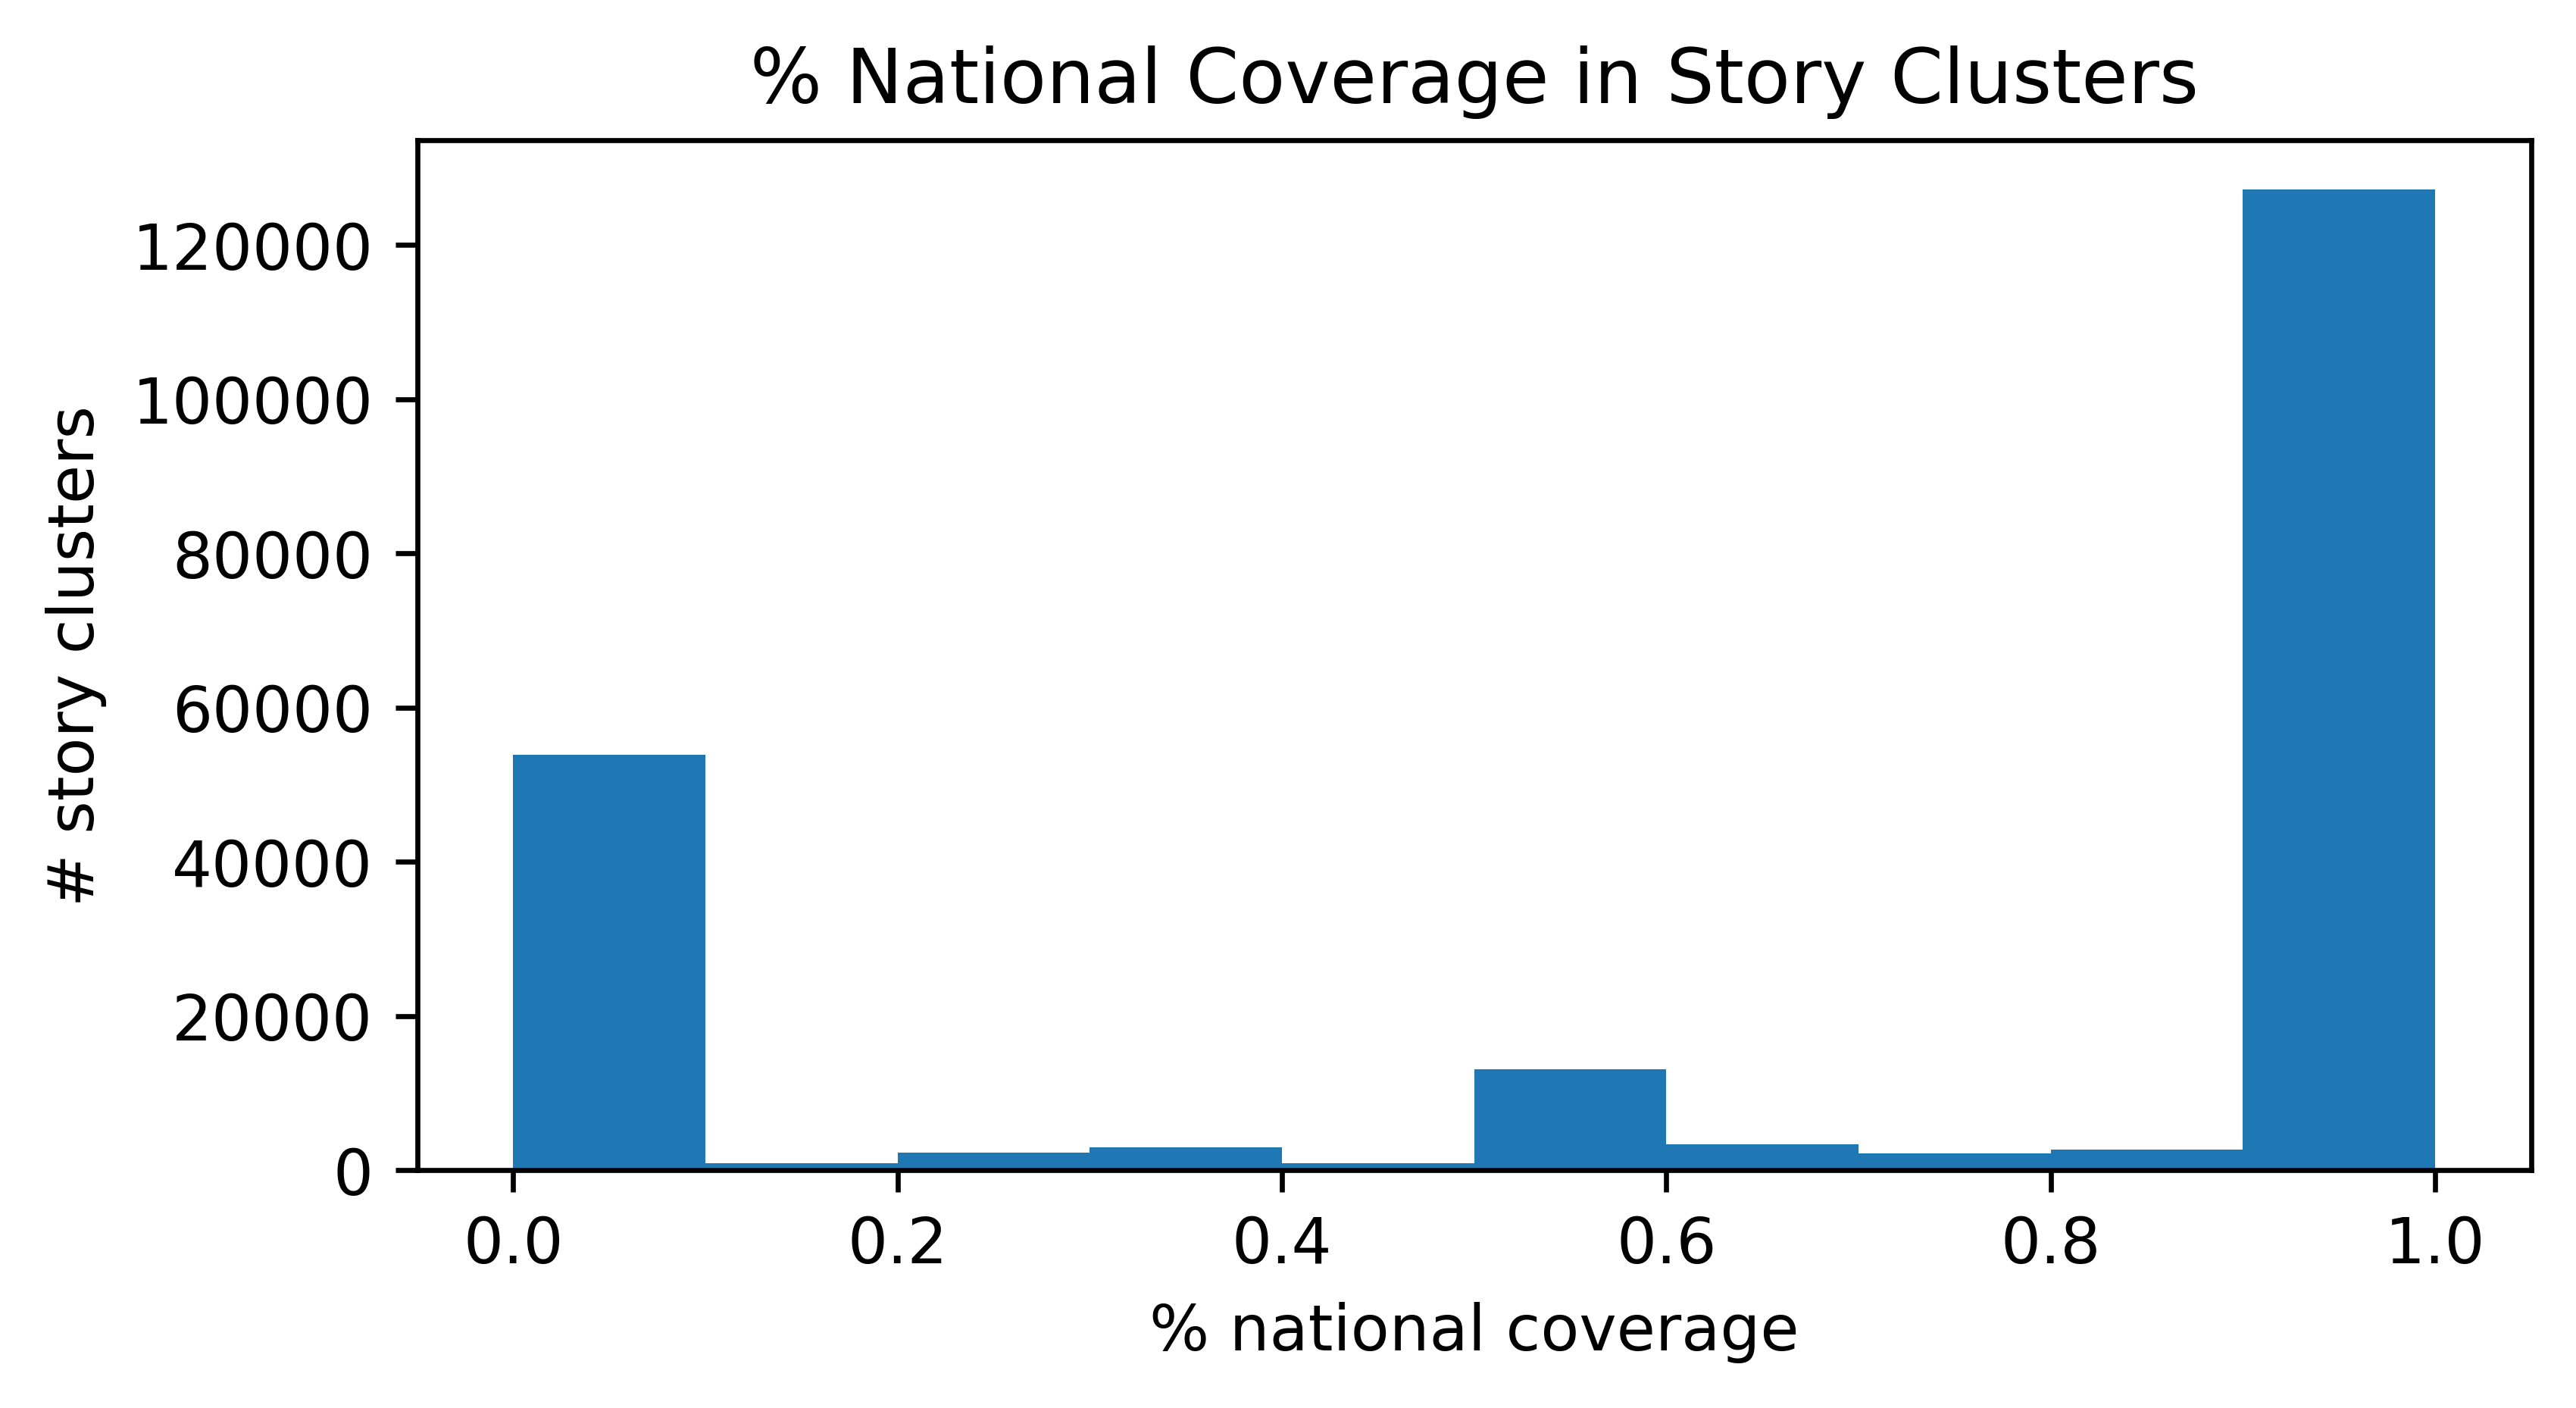

In [61]:
fig, axs = plt.subplots(figsize=(6, 3))
plt.hist(grouped["natProp"])
plt.title("% National Coverage in Story Clusters")
plt.xlabel("% national coverage")
plt.ylabel("# story clusters")

## Are larger stories more likely to be dominated by nat'l coverage? 

In [148]:
grouped.head(3)

key  \
clustNum                                                      
0.0       [12619, 28945, 43496, 43909, 43933, 44063, 442...   
1.0       [25945, 117195, 227832, 227858, 227989, 231314...   
2.0           [1857674, 2283482, 2283499, 2613520, 2660920]   

                                                     source  \
clustNum                                                      
0.0       [newyorkobserver, newyorkobserver, dailyherald...   
1.0       [newyorkobserver, thedailyrepublic, murrysvill...   
2.0       [dcgazette, themichellemalkinblog, themichelle...   

                                                      title  \
clustNum                                                      
0.0       [Prince Harry and Meghan Are Keeping Busy Whil...   
1.0       [Bob Iger Reasserts Control Over Disney Amid C...   
2.0       [Crisis Socialism: No Bailouts for Open Border...   

                                                    content  \
clustNum                                                      
0.0       [The Duke and Duchess of Sussex made their mov...   
1.0       [For years, the entertainment media industry s...   
2.0       [Crisis Socialism : No Bailouts for Open Borde...   

                                                       date  \
clustNum                                                      
0.0       [2020-04-07 00:00:00, 2020-04-14 00:00:00, 202...   
1.0       [2020-04-13 00:00:00, 2020-05-18 00:00:00, 202...   
2.0       [2020-03-19 00:00:00, 2020-03-18 00:00:00, 202...   

                                                   national  clustLen  first  \
clustNum                                                                       
0.0       [False, False, False, False, False, False, Fal...      1253    397   
1.0       [False, False, False, False, False, False, Fal...      1578   1405   
2.0                          [True, True, True, True, True]         5      1   

           natProp  nationalPercent  sourceCount  propFirstDay  
clustNum                                                        
0.0       0.949721         0.949721          115      0.001596  
1.0       0.826362         0.826362          201      0.001267  
2.0       1.000000         1.000000            4      0.800000

<ipython-input-159-f06fc3c3c3d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPack["sizeBin"] = pd.cut(dfPack["clustLen"], [0, 5, 30, 100, 300, 500])


Text(0, 0.5, 'cluster size (bins)')

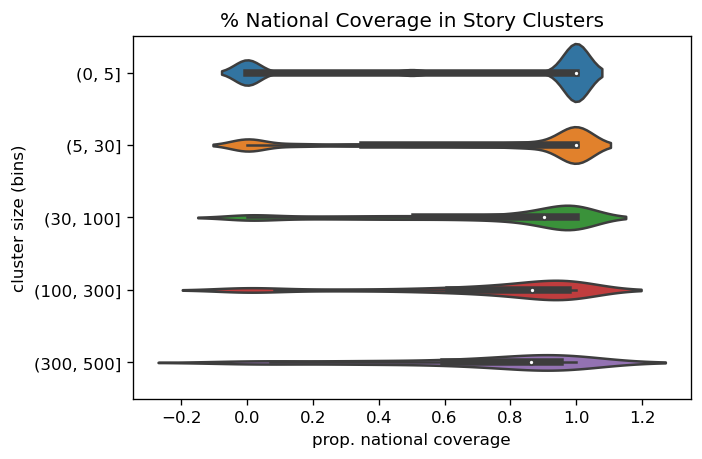

In [159]:
dfPack = grouped[[ "natProp", "sourceCount", "propFirstDay", "clustLen"]]
dfPack["sizeBin"] = pd.cut(dfPack["clustLen"], [0, 5, 30, 100, 300, 500])
dfPack = dfPack.dropna(subset=["sizeBin"])
dfPack[["natProp", "sizeBin"]]
#.groupby(by="sizeBin").agg(list).reset_index()
sns.violinplot(data=dfPack[["natProp", "sizeBin"]], x="natProp", y="sizeBin", orient="h", size=0)
plt.title("% National Coverage in Story Clusters")
plt.xlabel("prop. national coverage")
plt.ylabel("cluster size (bins)")

In [160]:
"""
fig, axs = plt.subplots(5, 1, figsize=(3, 6))

cutoffs = [0, 5, 50, 200, 1000, 1000000]

for i in range(len(cutoffs)-1): 
    minSize = cutoffs[i]
    maxSize = cutoffs[i+1]
    currDf = grouped[(grouped["clustLen"] > minSize) & (grouped["clustLen"] <= maxSize)]
    
    axs[i].hist(currDf["natProp"])
    axs[i].set_title(str(minSize) + " < |cluster| < " + str(maxSize))
plt.tight_layout()
"""

'\nfig, axs = plt.subplots(5, 1, figsize=(3, 6))\n\ncutoffs = [0, 5, 50, 200, 1000, 1000000]\n\nfor i in range(len(cutoffs)-1): \n    minSize = cutoffs[i]\n    maxSize = cutoffs[i+1]\n    currDf = grouped[(grouped["clustLen"] > minSize) & (grouped["clustLen"] <= maxSize)]\n    \n    axs[i].hist(currDf["natProp"])\n    axs[i].set_title(str(minSize) + " < |cluster| < " + str(maxSize))\nplt.tight_layout()\n'

## Who starts stories? 

In [169]:
#get the national or local status for the first article in a cluster 
justFirst = pd.DataFrame({"clustSize":grouped["clustLen"]})
justFirst["national"] = grouped.apply(lambda x: x["national"][x["first"]], axis=1)

#group all the first articles by cluster size (# of articles in a story)
firstGrouped = justFirst.groupby(by=["clustSize"]).agg(list).reset_index()
firstGrouped["natProp"] = firstGrouped["national"].apply(lambda x: sum(x)/len(x))

In [ ]:
# if time remake this with confidence intervals (barplot in sns)

Text(-41.33333333333333, 0.5, 'cluster size (bins)')

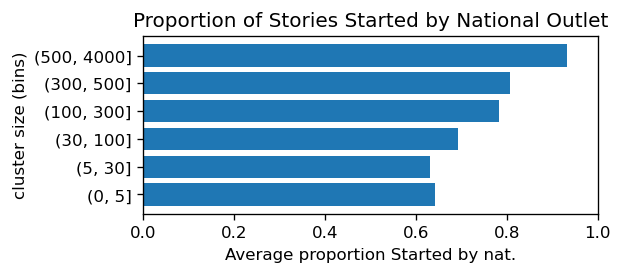

In [191]:
fig, axs = plt.subplots(figsize=(5, 2))
justFirst["sizeBin"] = pd.cut(justFirst["clustSize"], [0, 5, 30, 100, 300, 500, 4000])
justFirst["national"] = justFirst["national"].astype(int)

firstBins = justFirst.groupby(by=["sizeBin"]).agg(np.mean).reset_index()
firstBins["sizeBin"] = firstBins["sizeBin"].astype(str)
plt.barh(firstBins["sizeBin"], firstBins["national"])
plt.tight_layout()
plt.title("Proportion of Stories Started by National Outlet")
plt.xlabel("Average proportion Started by nat.")
plt.xlim(0, 1)
plt.ylabel("cluster size (bins)")

Text(0, 0.5, 'cluster size (bins)')

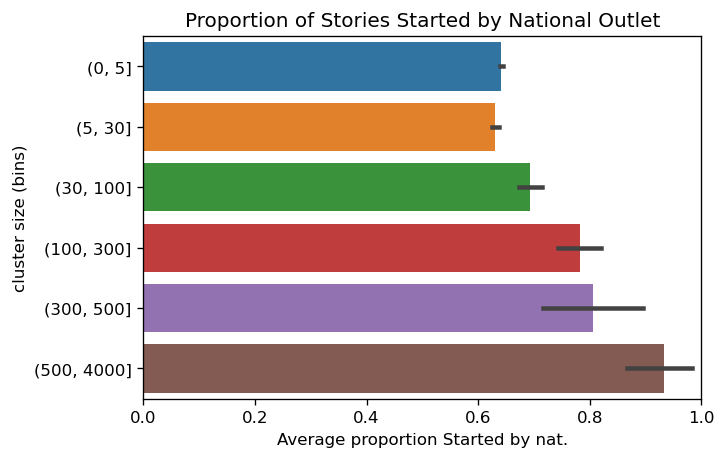

In [391]:
sns.barplot(data=justFirst, x="national", y="sizeBin")
plt.title("Proportion of Stories Started by National Outlet")
plt.xlabel("Average proportion Started by nat.")
plt.xlim(0, 1)
plt.ylabel("cluster size (bins)")

In [192]:
#plot first articles in news story based on local versus national and size of story 
"""
plt.rcParams['figure.dpi'] = 600
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].scatter(firstGrouped["clustSize"], firstGrouped["natProp"], alpha=.5)
axs[0].set_xlabel("articles in story", size=12)
axs[0].set_ylabel("% started by national", rotation=0, labelpad=70, size=12)
axs[0].set_xlim([0, 100])

axs[1].scatter(firstGrouped["clustSize"], firstGrouped["natProp"], alpha=.5)
axs[1].set_xlabel("articles in story", size=12)
#axs[1].set_ylabel("% started by national news", rotation=0, labelpad=70, size=12)
axs[1].set_xlim([100, 600])
fig.suptitle("Story Starters: National vs. Local", size=20)
"""

'\nplt.rcParams[\'figure.dpi\'] = 600\nfig, axs = plt.subplots(ncols=2, figsize=(10, 5))\naxs[0].scatter(firstGrouped["clustSize"], firstGrouped["natProp"], alpha=.5)\naxs[0].set_xlabel("articles in story", size=12)\naxs[0].set_ylabel("% started by national", rotation=0, labelpad=70, size=12)\naxs[0].set_xlim([0, 100])\n\naxs[1].scatter(firstGrouped["clustSize"], firstGrouped["natProp"], alpha=.5)\naxs[1].set_xlabel("articles in story", size=12)\n#axs[1].set_ylabel("% started by national news", rotation=0, labelpad=70, size=12)\naxs[1].set_xlim([100, 600])\nfig.suptitle("Story Starters: National vs. Local", size=20)\n'

### Same plot, but bin on the x axis for better understanding when x > 60 

In [193]:
"""
import numpy as np
bins = list(range(0, 61)) + list(np.arange(80, 300, 20))
justFirst["bin"] = pd.cut(justFirst["clustSize"], bins=bins)

#we now have grouping on the x axis. bins of size 1 for first 60, and size 20 for the rest 
groupedBins = justFirst.groupby(by="bin").agg(list).dropna()
groupedBins["nationalProp"] = groupedBins["national"].apply(lambda x: sum(x)/len(x))
groupedBins = groupedBins.reset_index()

groupedBins["right"] = groupedBins["bin"].apply(lambda x: x.right)
groupedBins["nationalProp"]

print("bins")
print(bins)

fig, axs = plt.subplots(ncols=2, figsize=(10,5))

first60 = groupedBins[groupedBins["right"] < 60]
axs[0].bar(first60["right"], first60["nationalProp"], width=1, align="edge")
axs[0].set_xlabel("articles in story", size=12)
axs[0].set_ylabel("% started by national", rotation=0, labelpad=70, size=12)
axs[0].set_ylim([0, 1])

remaining = groupedBins[groupedBins["right"] >= 60]
axs[1].bar(remaining["right"], remaining["nationalProp"], width=20, align="edge")
axs[1].set_xlabel("articles in story", size=12)
axs[1].set_ylim([0, 1])

fig.suptitle("Story Starters: National vs. Local", size=20)
"""

'\nimport numpy as np\nbins = list(range(0, 61)) + list(np.arange(80, 300, 20))\njustFirst["bin"] = pd.cut(justFirst["clustSize"], bins=bins)\n\n#we now have grouping on the x axis. bins of size 1 for first 60, and size 20 for the rest \ngroupedBins = justFirst.groupby(by="bin").agg(list).dropna()\ngroupedBins["nationalProp"] = groupedBins["national"].apply(lambda x: sum(x)/len(x))\ngroupedBins = groupedBins.reset_index()\n\ngroupedBins["right"] = groupedBins["bin"].apply(lambda x: x.right)\ngroupedBins["nationalProp"]\n\nprint("bins")\nprint(bins)\n\nfig, axs = plt.subplots(ncols=2, figsize=(10,5))\n\nfirst60 = groupedBins[groupedBins["right"] < 60]\naxs[0].bar(first60["right"], first60["nationalProp"], width=1, align="edge")\naxs[0].set_xlabel("articles in story", size=12)\naxs[0].set_ylabel("% started by national", rotation=0, labelpad=70, size=12)\naxs[0].set_ylim([0, 1])\n\nremaining = groupedBins[groupedBins["right"] >= 60]\naxs[1].bar(remaining["right"], remaining["nationalProp"

### Just look at story composition 

In [194]:
"""
grouped["nationalPercent"] = grouped["national"].apply(lambda x: sum(x)/len(x))

#group again by size of the story (number of articles in story)
clustLenDf = grouped[["clustLen", "nationalPercent"]].groupby(by=["clustLen"]).agg(list).reset_index()

clustLenDf["nationalAverage"] = clustLenDf["nationalPercent"].apply(np.mean)

#plt.scatter(clustLenDf["clustLen"], clustLenDf["nationalAverage"], alpha=.5)
#plt.xlim([0, 100])

plt.rcParams['figure.dpi'] = 600
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].scatter(clustLenDf["clustLen"], clustLenDf["nationalAverage"], alpha=.5)
axs[0].set_xlabel("articles in story", size=12)
axs[0].set_ylabel("% coverage that is national", rotation=0, labelpad=70, size=12)
axs[0].set_xlim([0, 100])

axs[1].scatter(clustLenDf["clustLen"], clustLenDf["nationalAverage"], alpha=.5)
axs[1].set_xlabel("articles in story", size=12)
#axs[1].set_ylabel("% started by national news", rotation=0, labelpad=70, size=12)
axs[1].set_xlim([100, 600])
fig.suptitle("Story Makeup: National vs. Local Coverage", size=20)
"""

'\ngrouped["nationalPercent"] = grouped["national"].apply(lambda x: sum(x)/len(x))\n\n#group again by size of the story (number of articles in story)\nclustLenDf = grouped[["clustLen", "nationalPercent"]].groupby(by=["clustLen"]).agg(list).reset_index()\n\nclustLenDf["nationalAverage"] = clustLenDf["nationalPercent"].apply(np.mean)\n\n#plt.scatter(clustLenDf["clustLen"], clustLenDf["nationalAverage"], alpha=.5)\n#plt.xlim([0, 100])\n\nplt.rcParams[\'figure.dpi\'] = 600\nfig, axs = plt.subplots(ncols=2, figsize=(10, 5))\naxs[0].scatter(clustLenDf["clustLen"], clustLenDf["nationalAverage"], alpha=.5)\naxs[0].set_xlabel("articles in story", size=12)\naxs[0].set_ylabel("% coverage that is national", rotation=0, labelpad=70, size=12)\naxs[0].set_xlim([0, 100])\n\naxs[1].scatter(clustLenDf["clustLen"], clustLenDf["nationalAverage"], alpha=.5)\naxs[1].set_xlabel("articles in story", size=12)\n#axs[1].set_ylabel("% started by national news", rotation=0, labelpad=70, size=12)\naxs[1].set_xlim([

## Outlet Variation
How many outlets are participating stories of different sizes? 

min participating sources: 1
max participating sources: 653


Text(0, 0.5, '# of clusters')

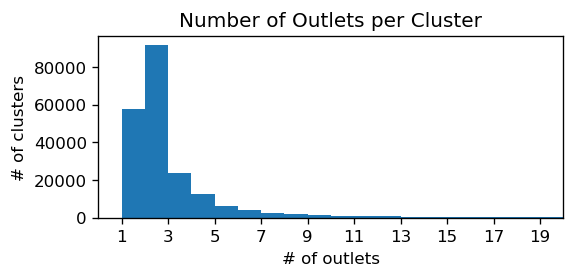

In [96]:
#number of participating outlets 
plt.rcParams["figure.dpi"] = 120
fig, axs = plt.subplots(figsize=(5, 2))
grouped["sourceCount"] = grouped["source"].apply(lambda x: len(set(x)))
print("min participating sources: " + str(min(grouped["sourceCount"])))
print("max participating sources: " + str(max(grouped["sourceCount"])))
plt.hist(grouped["sourceCount"], bins=np.arange(0, 653, 1))
plt.xticks(np.arange(1, 20, 2))
plt.xlim([0, 20])
plt.title("Number of Outlets per Cluster")
plt.xlabel("# of outlets")
plt.ylabel("# of clusters")

## Co-publishing?

In [101]:
#showing that the function below, "countFirst", works 
np.mean([True, True, False, False, False, False])

0.3333333333333333

In [104]:
def countFirst(dateList): 
    #get minimum of the dates 
    firstDay = min(dateList)
    return np.mean([date == firstDay for date in dateList])

propFirstDay = grouped["date"].apply(countFirst)

(array([ 6229., 12155., 10093., 21093., 63349.,  1964.,  8744.,  3878.,
         1131., 80778.]),
 array([2.27792162e-05, 1.00020501e-01, 2.00018223e-01, 3.00015945e-01,
        4.00013668e-01, 5.00011390e-01, 6.00009112e-01, 7.00006834e-01,
        8.00004556e-01, 9.00002278e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

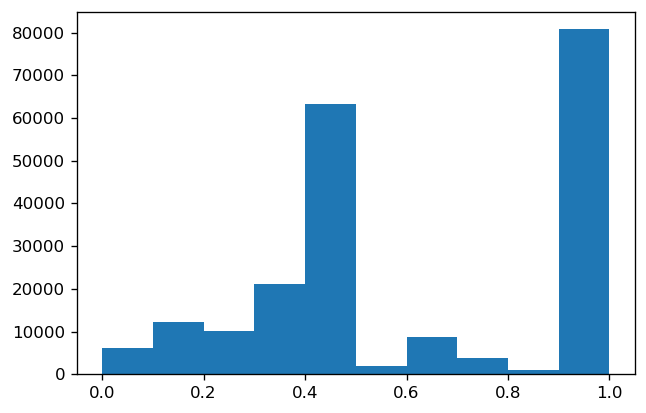

In [105]:
plt.hist(propFirstDay)

(array([6229., 7774., 2371., 2422., 2072.,  856., 1106.,  798., 1131.,
        2437.]),
 array([2.27792162e-05, 1.00020501e-01, 2.00018223e-01, 3.00015945e-01,
        4.00013668e-01, 5.00011390e-01, 6.00009112e-01, 7.00006834e-01,
        8.00004556e-01, 9.00002278e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

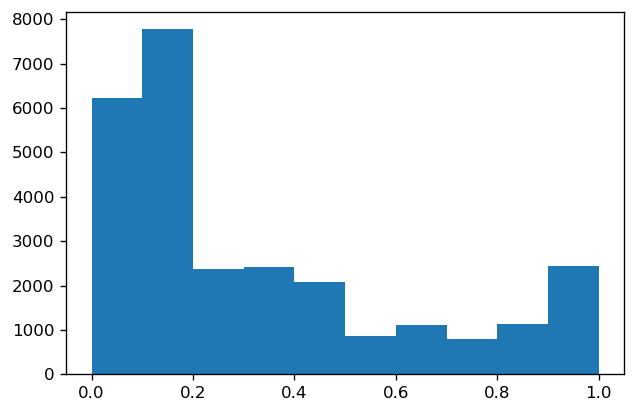

In [108]:
propFirstDayOver5 = grouped.loc[grouped["clustLen"] >5, "date"].apply(countFirst)
plt.hist(propFirstDayOver5)

<ipython-input-196-f0fdd44bca8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPack["sizeBin"] = pd.cut(dfPack["clustLen"], [0, 5, 30, 100, 300, 500])


Text(0, 0.5, 'cluster size (bins)')

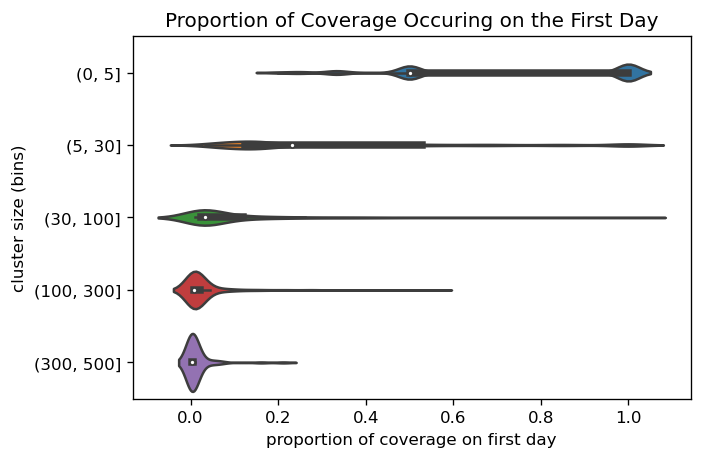

In [196]:
dfPack = grouped[[ "natProp", "sourceCount", "propFirstDay", "clustLen"]]
dfPack["sizeBin"] = pd.cut(dfPack["clustLen"], [0, 5, 30, 100, 300, 500])
dfPack = dfPack.dropna(subset=["sizeBin"])
dfPack[["propFirstDay", "sizeBin"]]
#.groupby(by="sizeBin").agg(list).reset_index()
sns.violinplot(data=dfPack[["propFirstDay", "sizeBin"]], x="propFirstDay", y="sizeBin", size=0)
plt.title("Proportion of Coverage Occuring on the First Day")
plt.xlabel("proportion of coverage on first day")
plt.ylabel("cluster size (bins)")

## Average Story Timeline

In [345]:
def dailyCoverageVolume(lowerLim, upperLim): 
    timeDf = grouped[["date", "national", "clustLen"]]
    def getDeltas(inList): 
        firstDay = min(inList)
        return [(currDate - firstDay) / np.timedelta64(1, "D") for currDate in inList]

    timeDf = timeDf[(timeDf["clustLen"] >= lowerLim)  & (timeDf["clustLen"] < upperLim)]
    timeDf["deltas"] = timeDf["date"].apply(getDeltas)

    import collections
    deltas = list(timeDf["deltas"])

    MAX_DAY = 365
    def getProps(inList): 
        listLen = len(inList)
        counted = collections.Counter(inList)
        outDict = {k:(v/listLen) for k,v in counted.items()}

        #we have 0 "probability" of getting values
        #that never occur 

        for i in range(0, MAX_DAY): 
            if i not in outDict: 
                outDict[i] = 0

        return outDict

    dayMeans = {}
    for i, deltaList in enumerate(deltas): 
        coverageProps = getProps(deltaList)
        for k, v in coverageProps.items(): 
            if k not in dayMeans: 
                dayMeans[k] = [v]
            else: 
                dayMeans[k].append(v)

    coveragePropDf = pd.DataFrame.from_dict({k:np.mean(v) for k,v in dayMeans.items()}, orient="index", \
                           columns=["coverageProp"]).reset_index().sort_values("index")
    return coveragePropDf

In [346]:
under10 = dailyCoverageVolume(0, 10)
df10_50 = dailyCoverageVolume(10, 50)
dfover_50 = dailyCoverageVolume(50, 2000)

In [369]:
under10

index  coverageProp
1      0.0  6.717204e-01
0      1.0  1.265883e-01
2      2.0  3.679136e-02
3      3.0  1.945446e-02
4      4.0  1.259750e-02
..     ...           ...
360  360.0  1.994239e-06
361  361.0  7.251779e-07
362  362.0  0.000000e+00
363  363.0  5.640272e-07
364  364.0  2.538123e-06

[365 rows x 2 columns]

In [381]:
allBinsDf = under10.copy(deep=True)
allBinsDf = allBinsDf.rename(columns={"coverageProp":"under10"})
allBinsDf["10_50"] = df10_50["coverageProp"]
allBinsDf["50_1000"] = dfover_50["coverageProp"]

Text(0.5, 1.0, 'Average Proportion of Coverage on Each Day of Story Cluster')

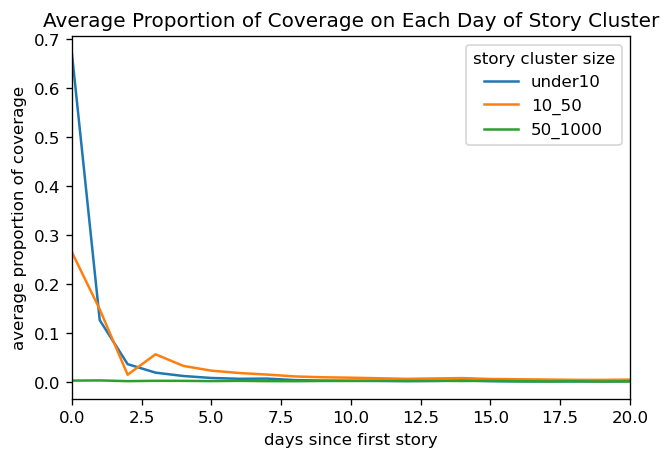

In [394]:
allBinsMelted = allBinsDf.melt(id_vars=["index"]).rename(columns={"variable":"story cluster size"})
sns.lineplot(data=allBinsMelted, x="index", y="value", hue="story cluster size")
plt.xlim(0, 20)
plt.xlabel("days since first story")
plt.ylabel("average proportion of coverage")
plt.title("Average Proportion of Coverage on Each Day of Story Cluster")

In [335]:
dayCountDf = pd.DataFrame(dayMeans)
dayCountDf = pd.melt(dayCountDf)


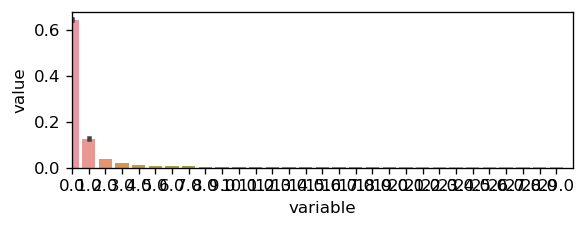

In [344]:
under30 = dayCountDf[dayCountDf["variable"] < 30]
fig, axs = plt.subplots(figsize=(5, 2))
sns.barplot(data=under30, x="variable", y="value")
plt.xlim(0, 30)
plt.tight_layout()

## Create a map using geographic links/time series? 

In [7]:
## first try to just plot on a static us map 
import geopandas as gpd
from shapely.geometry import Point, LineString

In [8]:
states = gpd.read_file("/home/blitt/reference/geospatial/shapeFiles/cb_2018_us_state_5m")

#revisit projection at some point to double check. Looks close enough for our purposes, for now 
print(states.crs)

states.head(2)

epsg:4269


STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
0      31  01779792  0400000US31    31     NE    Nebraska   00  198956658395   
1      53  01779804  0400000US53    53     WA  Washington   00  172112588220   

        AWATER                                           geometry  
0   1371829134  POLYGON ((-104.05351 41.15726, -104.05267 41.2...  
1  12559278850  MULTIPOLYGON (((-122.32834 48.02134, -122.3217...

In [9]:
#local sources with long lat data 
localDf = merged[merged["national"] == False].dropna(subset=["lon", "lat"])

#since each source has the same exact location we only need one row per source 
localDf = localDf.drop_duplicates(subset=["source"])
print(len(localDf))

articlePoints = [Point(lonLat[0], lonLat[1]) for lonLat in zip(localDf["lon"], localDf["lat"])]
pointGdf = gpd.GeoDataFrame(localDf, geometry=articlePoints)

313


(10.0, 75.0)

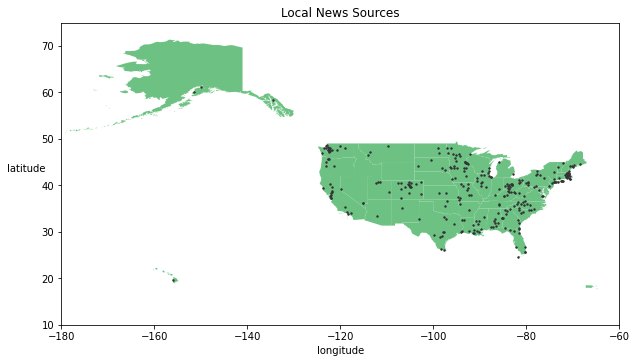

In [10]:
pointGdf.plot(ax=states.plot(figsize=(10, 6), color="#6dc283"), color="#323333", marker = "o", markersize=2)
plt.title("Local News Sources")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-180, -60])
plt.ylim([10, 75])

In [14]:
#now try to visualize lines between outlets!
localDf = merged[merged["national"] == False].dropna(subset=["lon", "lat"])
localDf["latLon"] = list(zip(localDf["lon"], localDf["lat"],))
localGrouped = localDf[["source", "date", "latLon", "clustNum"]].groupby(by=["clustNum"]).agg(list)


In [92]:
edgeDict = {}

for sourceList in tqdm(localGrouped["source"]): 
    if len(sourceList) < 3000: 
        for i in range(len(sourceList)): 
            sourceA = sourceList[i]
            for j in range(i, len(sourceList)): 
                sourceB = sourceList[j]
                if sourceA != sourceB: 
                    if (sourceA, sourceB) not in edgeDict: 
                        edgeDict[(sourceA, sourceB)] = 1
                    else: 
                        edgeDict[(sourceA, sourceB)] += 1

100%|██████████| 83588/83588 [00:07<00:00, 11646.86it/s]


In [93]:
def getFirst(inList): 
    return inList[0]

sourceLocDf = localDf[["source", "latLon"]].groupby(by="source").agg(lambda x: x.iloc[0]).reset_index()
sourceLocDf.head(2)

source                     latLon
0  addisoncountyindependent    (-73.16734, 44.0153371)
1        advertiserdemocrat  (-70.5448096, 44.2139566)

In [94]:
edgeDf = pd.DataFrame.from_dict(edgeDict, orient="index").reset_index().rename(columns={"index":"sourcePair", 0:"edgeCount"})
edgeDf[["s1", "s2"]] = edgeDf["sourcePair"].to_list()
edgeDf.head(3)

edgeDf = pd.merge(edgeDf, sourceLocDf, left_on="s1", right_on="source").drop(columns=["source", "sourcePair"])
edgeDf = pd.merge(edgeDf, sourceLocDf, left_on="s2", right_on="source").drop(columns=["source"])
edgeDf.head(3)

edgeCount                       s1           s2  \
0         31          newyorkobserver  dailyherald   
1       2514          murrysvillestar  dailyherald   
2       2516  pittsburghtribunereview  dailyherald   

                           latLon_x                   latLon_y  
0         (-74.0059728, 40.7127753)  (-87.9806265, 42.0883603)  
1  (-79.69754499999998, 40.4284015)  (-87.9806265, 42.0883603)  
2         (-79.9958864, 40.4406248)  (-87.9806265, 42.0883603)

In [96]:
lines = [LineString(item) for item in edgeDf["geoPair"]]

lineGdf = gpd.GeoDataFrame(edgeDf, geometry=lines)

In [97]:
plt.rcParams["figure.dpi"] = 200

(20.0, 50.0)

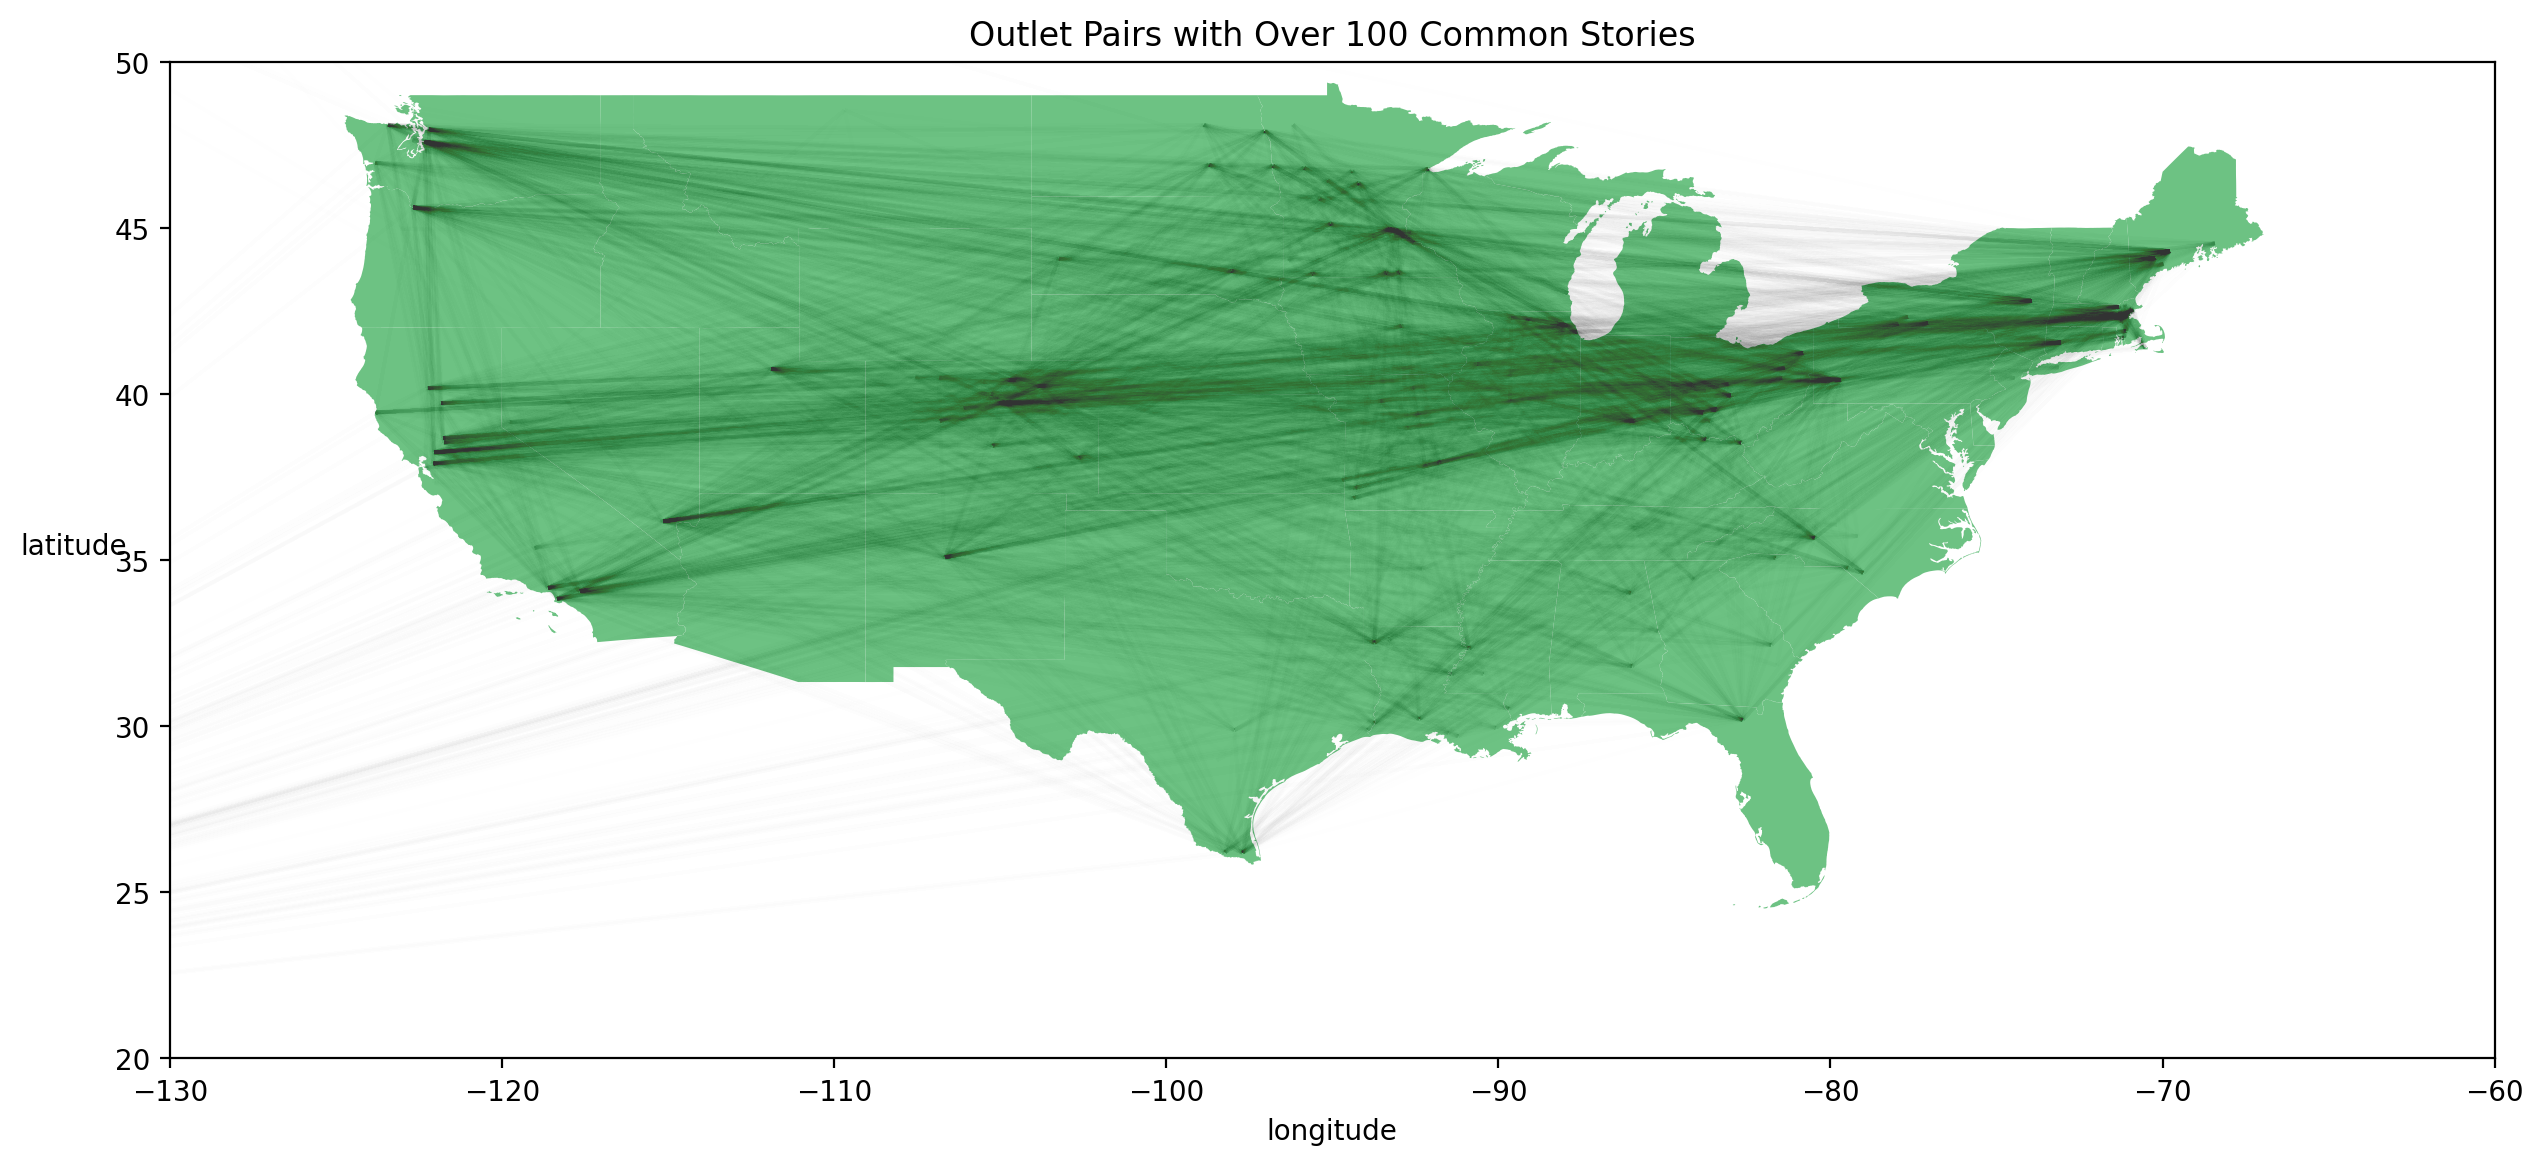

In [98]:
EDGE_CUTOFF = 100
over10Gdf = lineGdf[lineGdf["edgeCount"] > EDGE_CUTOFF]
over10Gdf.plot(ax=states.plot(figsize=(15, 10), color="#6dc283"), color="#323333", alpha=.003)
#need to think about scaling for the number of articles produced? 
#obviously small outlets aren't going to have many connections 
plt.title("Outlet Pairs with Over " + str(EDGE_CUTOFF) + " Common Stories")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-130, -60])
plt.ylim([20, 50])

In [ ]:
over10Gdf = lineGdf[lineGdf["edgeCount"] > 100]
over10Gdf.plot(ax=states.plot(figsize=(15, 10), color="#6dc283"), color="#323333", alpha=.003)
#need to think about scaling for the number of articles produced? 
#obviously small outlets aren't going to have many connections 
plt.title("Outlet Pairs with Over 10 Common Stories")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-180, -60])
plt.ylim([10, 75])

## OLD:  Create outlet level graph for better visualization 

In [194]:
merged.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'article_id',
       'sourcedomain_id', 'date', 'title', 'content', 'url_x', 'fips',
       'source', 'description', 'onlinesince', 'rank', 'state', 'city', 'lon',
       'lat', 'county', 'total_population', 'white_pct', 'black_pct',
       'hispanic_pct', 'nonwhite_pct', 'foreignborn_pct', 'female_pct',
       'age29andunder_pct', 'age65andolder_pct', 'median_hh_inc',
       'clf_unemploy_pct', 'lesshs_pct', 'lesscollege_pct',
       'lesshs_whites_pct', 'lesscollege_whites_pct', 'rural_pct',
       'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3', 'national', 'id',
       'author', 'url', 'published', 'published_utc', 'collection_utc', 'key',
       'namedEntities', 'embedding', 'clustNum'],
      dtype='object')

### The question here is: 
if we have, within a given cluster, (outlet_1, outlet_2, outlet_1, outlet_3) as our timeline, do we think that 
influence is occuring from outlet_2 to outlet_1. The less nuanced and easier question revolves around when a particular
topic or news event to cover is introduced, and since outlet_3 doesn't introduce anything completely new to outlet 1
then we say no. At some point we should consider the reverse case. 

In [698]:
#get pairwise information
#by sorting in this way then calling drop_duplicates, we only consider the first mention of a story by 
#an outlet. Simplifies the analysis but introduces an assumption 
#example: merged.head(300)[["clustNum", "source", "date"]].sort_values(["clustNum", "source", "date"]).head(20)
pairwise = merged.sort_values(["clustNum", "source", "date"]).drop_duplicates(subset=["clustNum", "source"])

#group into clusters
pairwise = pairwise.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "content", "embedding", "namedEntities"])
pairwise = pairwise.groupby(by="clustNum").agg(list)
pairwise["clustSize"] = pairwise["key"].apply(len)
pairwise = pairwise[pairwise["clustSize"] < 600].drop(columns=["clustSize"])




In [699]:

def getPairwise(inList): 
    if type(inList) == float: 
        print(len(inList))
        print(inList)
        
    return [(item1, item2) for item2 in inList for item1 in inList]

#applied across an entire series 
def getPairwiseSeries(inSeries): 
    return inSeries.apply(getPairwise)

pairwise = pairwise.apply(getPairwiseSeries)
pairwise = pairwise.apply(pd.Series.explode)
pairwise[["date1", "date2"]] = pd.DataFrame(pairwise["date"].tolist(), index=pairwise.index)

In [700]:
pairwise.shape

(653030, 45)

In [701]:
def getFirst(inList):
    return inList[0]

aggDict = {
    "article_id":list, 
    "sourcedomain_id":getFirst, 
    "date":list, 
    "title":list, 
    "url_x":list, 
    "fips":list, 
    "source":getFirst, 
    "description":list, 
    "onlinesince":getFirst, 
    "rank":getFirst, 
    "state":getFirst, 
    "city":getFirst, 
    "lon":getFirst,
    "lat":getFirst, 
    "county":getFirst, 
    "total_population":getFirst, 
    "white_pct":getFirst, 
    "national":getFirst,
    "date1":list, 
    "date2":list
}

In [702]:
#keep only pairs where one outlet preceeds the other 
pairwise = pairwise[np.where(pairwise["date1"] < pairwise["date2"], True, False)]

#now group by pairs or outlets. 
#TODO: make it so that outlet level info is not in a list and article level info IS
outletEdges = pairwise.groupby(by="source").agg(list)
outletEdges["weight"] = outletEdges["key"].apply(len)

In [703]:
outletEdges["lat"] = outletEdges["lat"].apply(lambda x: x[0])
outletEdges["lon"] = outletEdges["lon"].apply(lambda x: x[0])

In [704]:
outletEdges[["lat1", "lat2"]] = pd.DataFrame(outletEdges["lat"].tolist(), index=outletEdges.index)
outletEdges[["lon1", "lon2"]] = pd.DataFrame(outletEdges["lon"].tolist(), index=outletEdges.index)

In [705]:
outletEdges[["state1", "state2"]] = pd.DataFrame(outletEdges["state"].apply(getFirst).tolist(), index=outletEdges.index)

In [706]:
localEdges = outletEdges.dropna(subset=["lat1", "lat2", "lon1", "lon2"])

In [707]:
zippedCols = list(zip(localEdges["lon1"], localEdges["lat1"], localEdges["lon2"], localEdges["lat2"]))
lines = [LineString([(item[0], item[1]),(item[2], item[3])]) for item in zippedCols]

In [708]:
localEdgesGdf = gpd.GeoDataFrame(localEdges, geometry=lines)

In [709]:
localEdgesGdf[["weight", "geometry"]]

weight  \
source                                                      
(addisoncountyindependent, bartonchronicle)             1   
(addisoncountyindependent, cascadebusinessnews)         1   
(addisoncountyindependent, chronicleindependent)        1   
(addisoncountyindependent, claytontribune)              1   
(addisoncountyindependent, fallschurchnewspress)        1   
...                                                   ...   
(yellowspringsnews, thewanderer)                        1   
(yellowspringsnews, vancouverbusinessjournal)           1   
(yellowspringsnews, vashonmauryislandbeachcomber)       1   
(yellowspringsnews, vicksburgpost)                      1   
(yellowspringsnews, whidbeynewstimes)                   1   

                                                                                            geometry  
source                                                                                                
(addisoncountyindependent, bartonchronicle)        LINESTRING (-73.16734 44.01534, -72.17626 44.7...  
(addisoncountyindependent, cascadebusinessnews)    LINESTRING (-73.16734 44.01534, -121.31531 44....  
(addisoncountyindependent, chronicleindependent)   LINESTRING (-73.16734 44.01534, -80.60702 34.2...  
(addisoncountyindependent, claytontribune)         LINESTRING (-73.16734 44.01534, -83.40099 34.8...  
(addisoncountyindependent, fallschurchnewspress)   LINESTRING (-73.16734 44.01534, -77.17109 38.8...  
...                                                                                              ...  
(yellowspringsnews, thewanderer)                   LINESTRING (-83.88687 39.80645, -70.81507 41.6...  
(yellowspringsnews, vancouverbusinessjournal)      LINESTRING (-83.88687 39.80645, -122.67609 45....  
(yellowspringsnews, vashonmauryislandbeachcomber)  LINESTRING (-83.88687 39.80645, -122.45985 47....  
(yellowspringsnews, vicksburgpost)                 LINESTRING (-83.88687 39.80645, -90.87788 32.3...  
(yellowspringsnews, whidbeynewstimes)              LINESTRING (-83.88687 39.80645, -122.64842 48....  

[31844 rows x 2 columns]

Text(0.5, 0.98, 'Metro-Area News Networks')

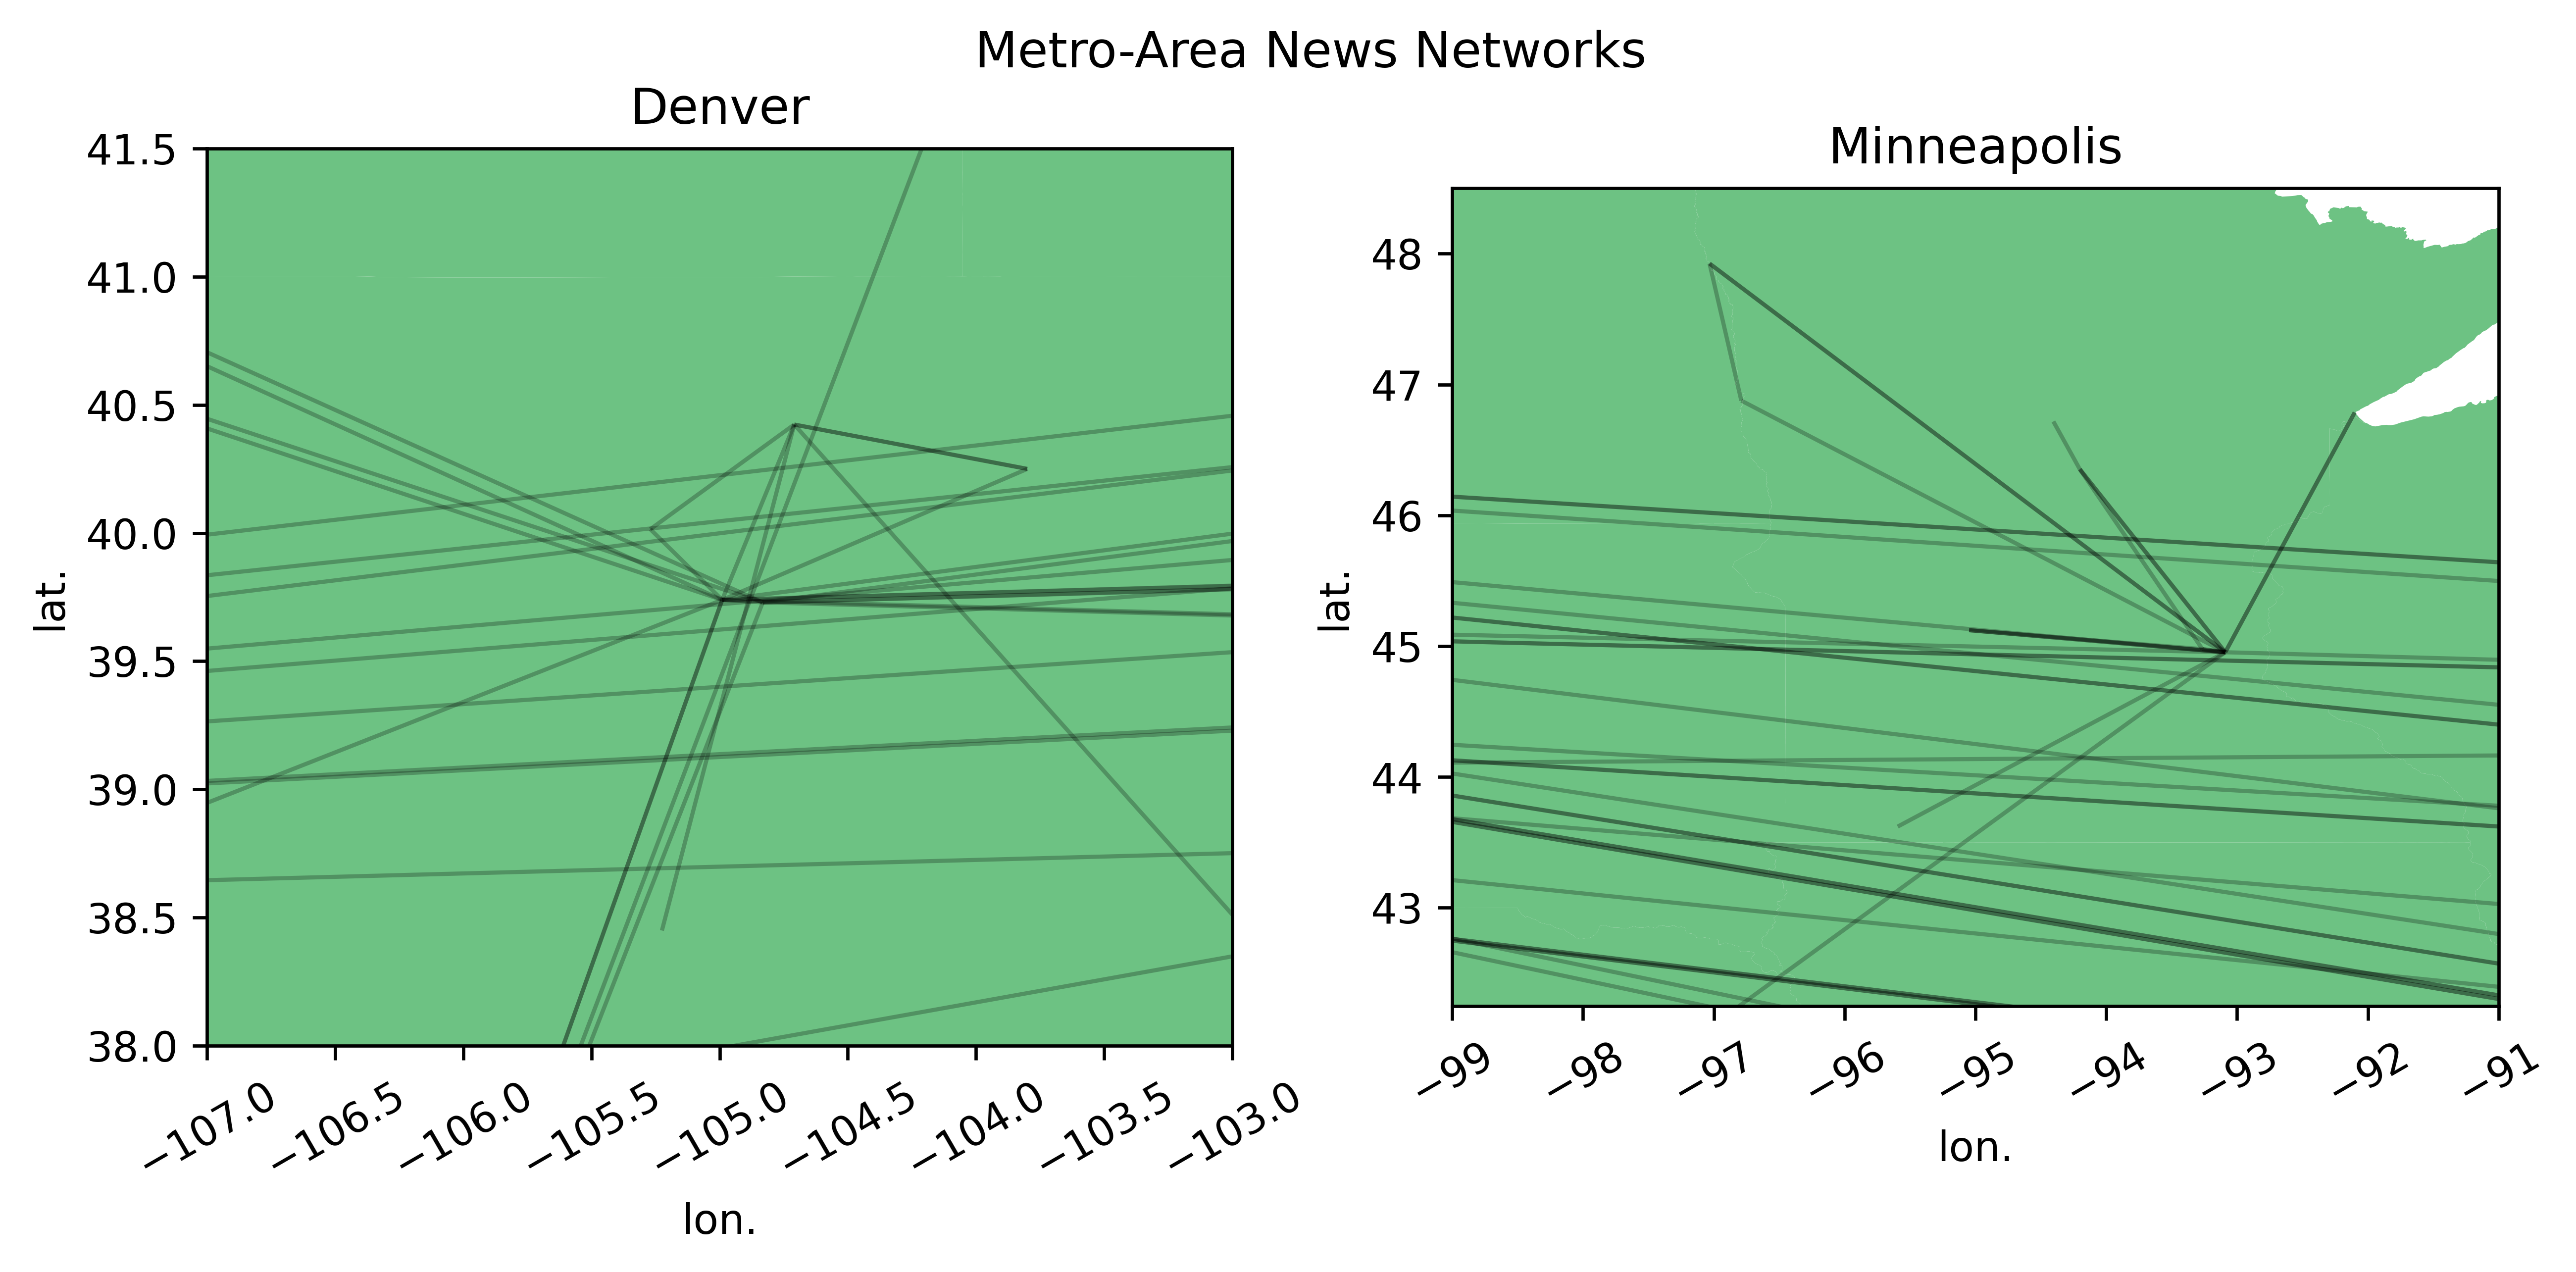

In [479]:
#first try top 200 weights
cols = 2
fig, axs = plt.subplots(ncols=cols, figsize=(10, 4))
xlims = [[-107, -103], [-98.5, -91.5]]
ylims = [[38, 41.5], [42.25, 48.5]]
metroNames = ["Denver", "Minneapolis"]

i = 0 
for k in range(cols): 
    top200 = localEdgesGdf.sort_values("weight", ascending=False).head(200)
    states.plot(color="#6dc283", ax=axs[k])
    top200.plot(ax=axs[k],alpha=.25, legend=True, linewidth=1, color="black")
    axs[k].set_xlim(xlims[i])
    axs[k].set_ylim(ylims[i])
    plt.draw()
    axs[k].set_xticks(axs[k].get_xticks())
    axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=30)
    axs[k].set_title(metroNames[i])
    axs[k].set_xlabel("lon.")
    axs[k].set_ylabel("lat.")
    
    i += 1
    #need to think about scaling for the number of articles produced? 
    #obviously small outlets aren't going to have many connections 
    #plt.title("Outlet Pairs with Over 10 Common Stories")
    #plt.xlabel("longitude")
    #plt.ylabel("latitude", rotation=0, labelpad=15)

fig.suptitle("Metro-Area News Networks")

In [484]:
top200["city"]

27655    [(Seattle, Vancouver), (Seattle, Vancouver), (...
27691    [(Seattle, Columbus), (Seattle, Columbus), (Se...
22657    [(Denver, Greeley), (Denver, Greeley), (Denver...
27506    [(Seattle, Albuquerque), (Seattle, Albuquerque...
735      [(Albuquerque, Vancouver), (Albuquerque, Vanco...
                               ...                        
21235    [(Vancouver, Lowell), (Vancouver, Lowell), (Va...
5963     [(Arlington Heights, Murrysville), (Arlington ...
6084     [(Arlington Heights, Kailua Kona), (Arlington ...
6489     [(Woodland Hills, Seattle), (Woodland Hills, S...
9650     [(Grand Forks, Fargo), (Grand Forks, Fargo), (...
Name: city, Length: 200, dtype: object

### Try to split up into edges coming into and out of these areas 

In [ ]:
localEdgesGdf = localEdgesGdf.reset_index()
localEdgesGdf[["source1", "source2"]] = pd.DataFrame(localEdgesGdf["source"].tolist(), index=localEdgesGdf.index)
localEdgesGdf[["city1", "city2"]] = pd.DataFrame(localEdges["city"].apply(getFirst).tolist(), index=localEdgesGdf.index)


In [497]:
#remember that city1 preceeds city2, so if we want cities influencing we take cities in the left column 
top200 = localEdgesGdf.sort_values("weight", ascending=False).head(200)
fromMinn = top200.loc[((top200["city1"] == "Minneapolis") | (top200["city1"] == "St. Paul")) & ((top200["city2"] != "Minneapolis") & (top200["city2"] != "St. Paul")), ["weight", "source", "geometry"]]
toMinn = top200.loc[((top200["city2"] == "Minneapolis") | (top200["city2"] == "St. Paul")) & ((top200["city1"] != "Minneapolis") & (top200["city1"] != "St. Paul")), ["weight", "source", "geometry"]]


17682    72
17615    71
17513    70
17527    68
17631    58
17503    51
19305    50
19372    48
Name: weight, dtype: int64
27631    57
30977    54
711      53
21183    49
25447    49
20643    49
9614     49
7737     47
Name: weight, dtype: int64


Text(0.5, 0.98, "Direction of 'Influence': Minneapolis-St. Paul")

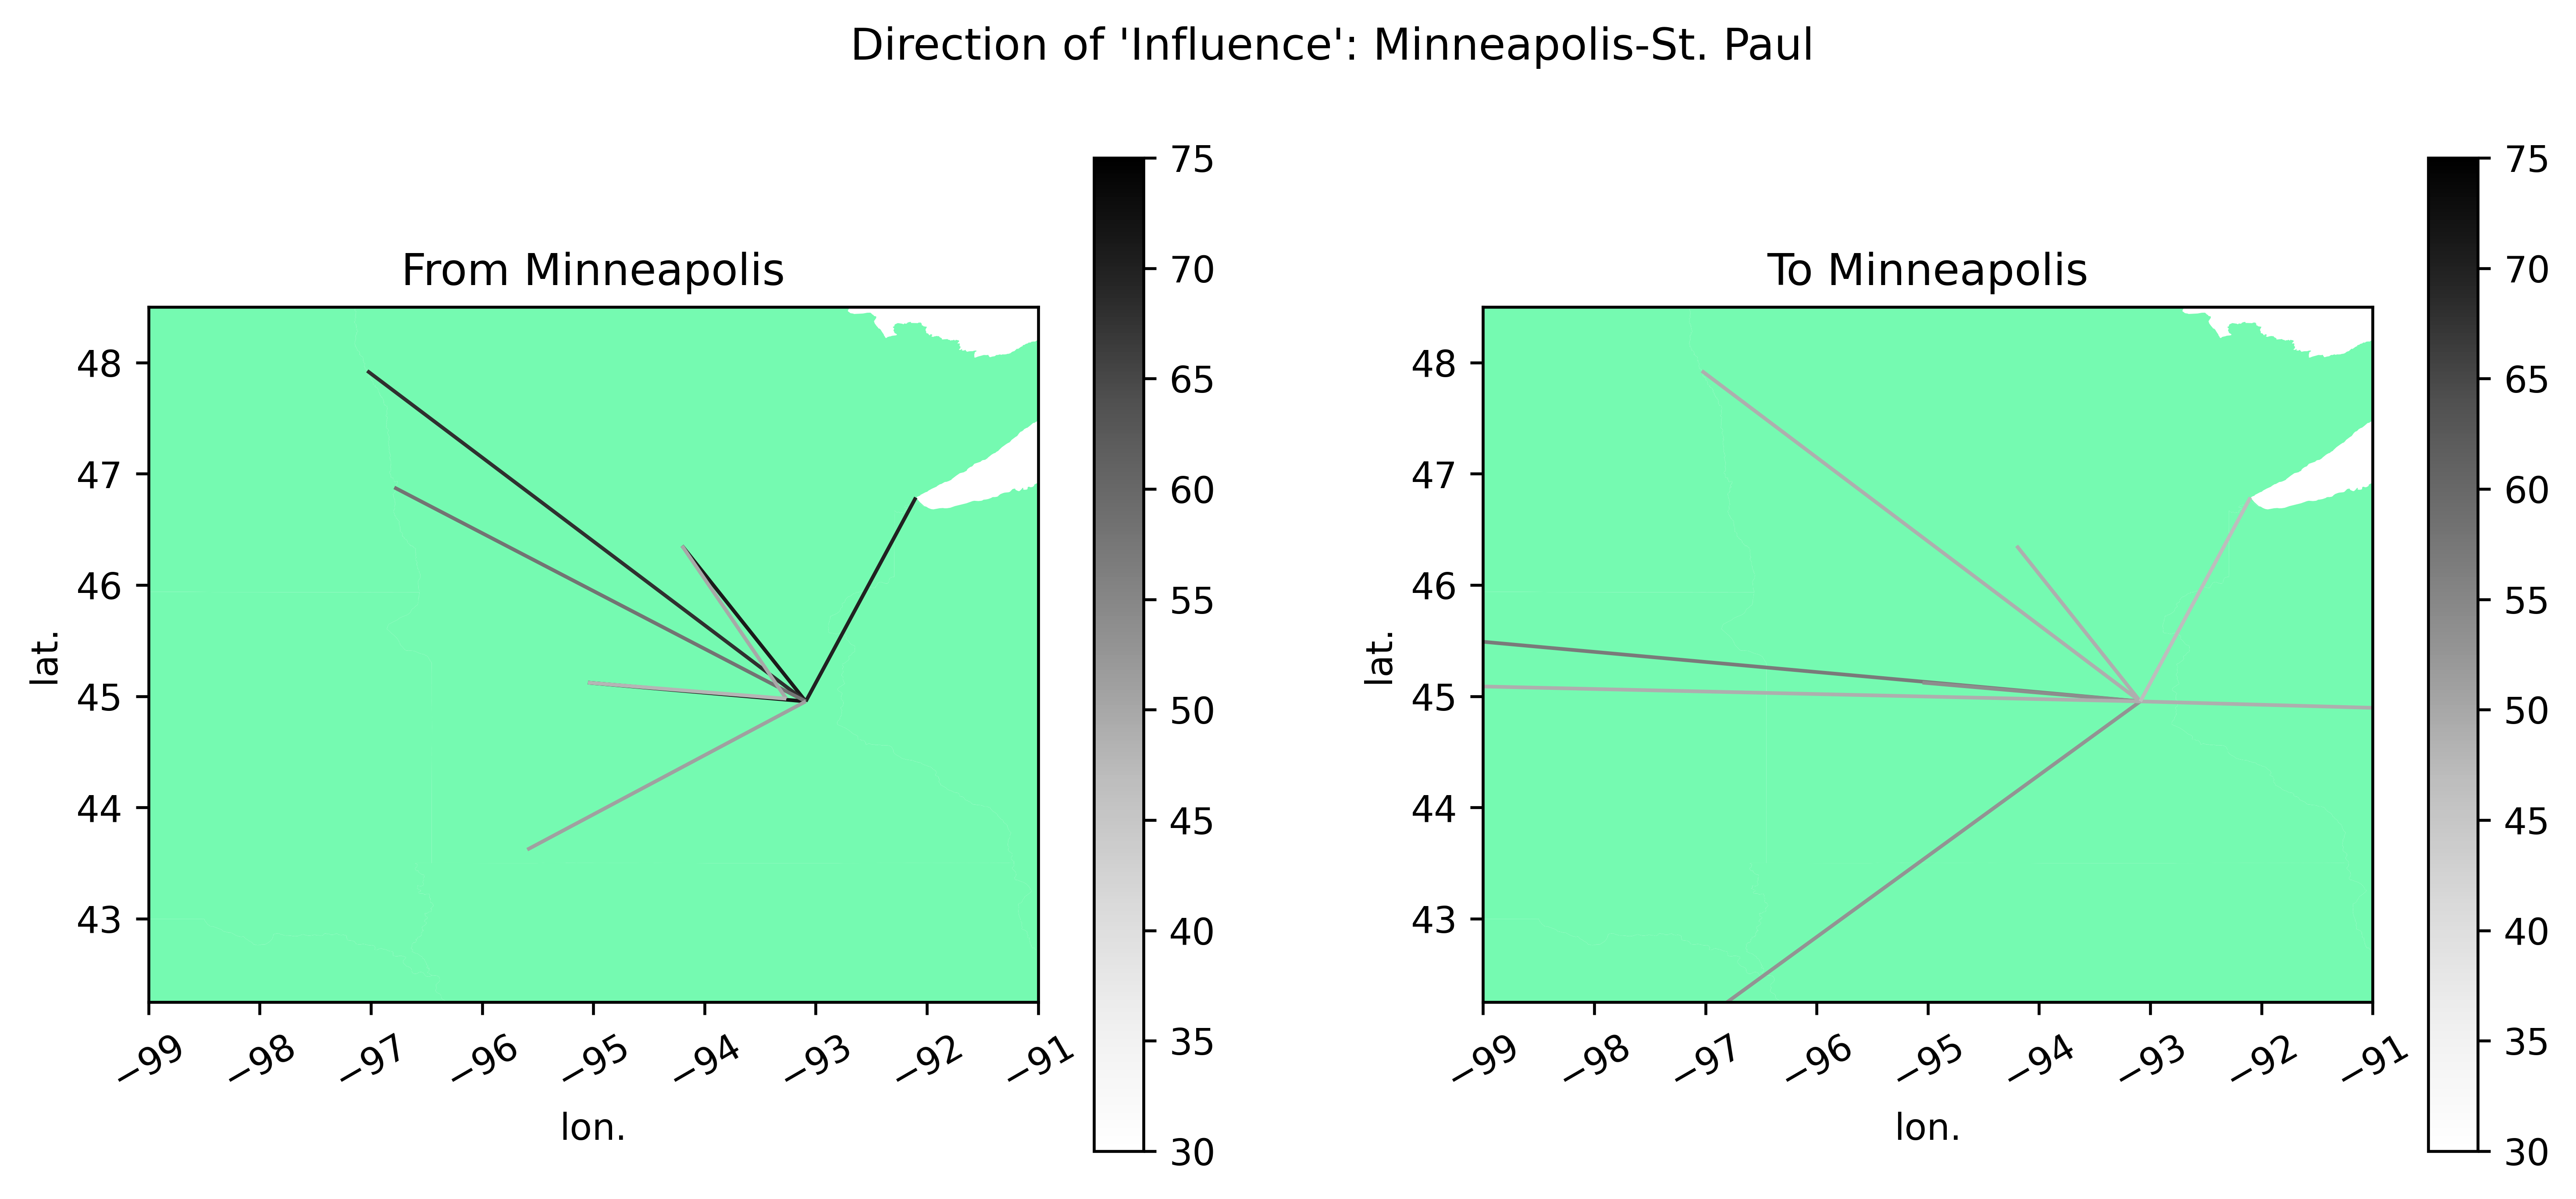

In [538]:

#first try top 200 weights
dfs = [fromMinn, toMinn]
cols = 2

fig, axs = plt.subplots(ncols=cols, figsize=(12, 5))
xlims = [[-98.5, -91.5], [-98.5, -91.5]]
ylims = [[42.25, 48.5], [42.25, 48.5]]
metroNames = ["From Minneapolis", "To Minneapolis"]

i = 0 
for k in range(cols): 
    df = dfs[i].sort_values("weight", ascending=False).head(200)
    states.plot(color="#75fab1", ax=axs[k])
    print(df["weight"])
    df.plot(ax=axs[k],alpha=1, legend=True, linewidth=1, column="weight", cmap="Greys", vmin=30, vmax=75)
    axs[k].set_xlim(xlims[i])
    axs[k].set_ylim(ylims[i])
    plt.draw()
    axs[k].set_xticks(axs[k].get_xticks())
    axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=30)
    axs[k].set_title(metroNames[i])
    axs[k].set_xlabel("lon.")
    axs[k].set_ylabel("lat.")
    
    i += 1
    #need to think about scaling for the number of articles produced? 
    #obviously small outlets aren't going to have many connections 
    #plt.title("Outlet Pairs with Over 10 Common Stories")
    #plt.xlabel("longitude")
    #plt.ylabel("latitude", rotation=0, labelpad=15)

fig.suptitle("Direction of 'Influence': Minneapolis-St. Paul")

In [536]:
cityList = ["Denver", "Aurora"]
fromDenverBoulder = top200.loc[(top200["city1"].isin(cityList)) & (~top200["city2"].isin(cityList)), ["weight", "source", "geometry"]]
toDenverBoulder = top200.loc[(top200["city2"].isin(cityList)) & (~top200["city1"].isin(cityList)), ["weight", "source", "geometry"]]

22657    177
22650     62
22598     59
22750     49
22811     48
Name: weight, dtype: int64
591      90
27512    89
27663    84
743      79
21062    69
21214    64
15656    62
25326    62
25480    61
13753    61
26954    52
27106    50
13602    47
15505    47
Name: weight, dtype: int64


Text(0.5, 0.98, "Direction of 'Influence': Denver")

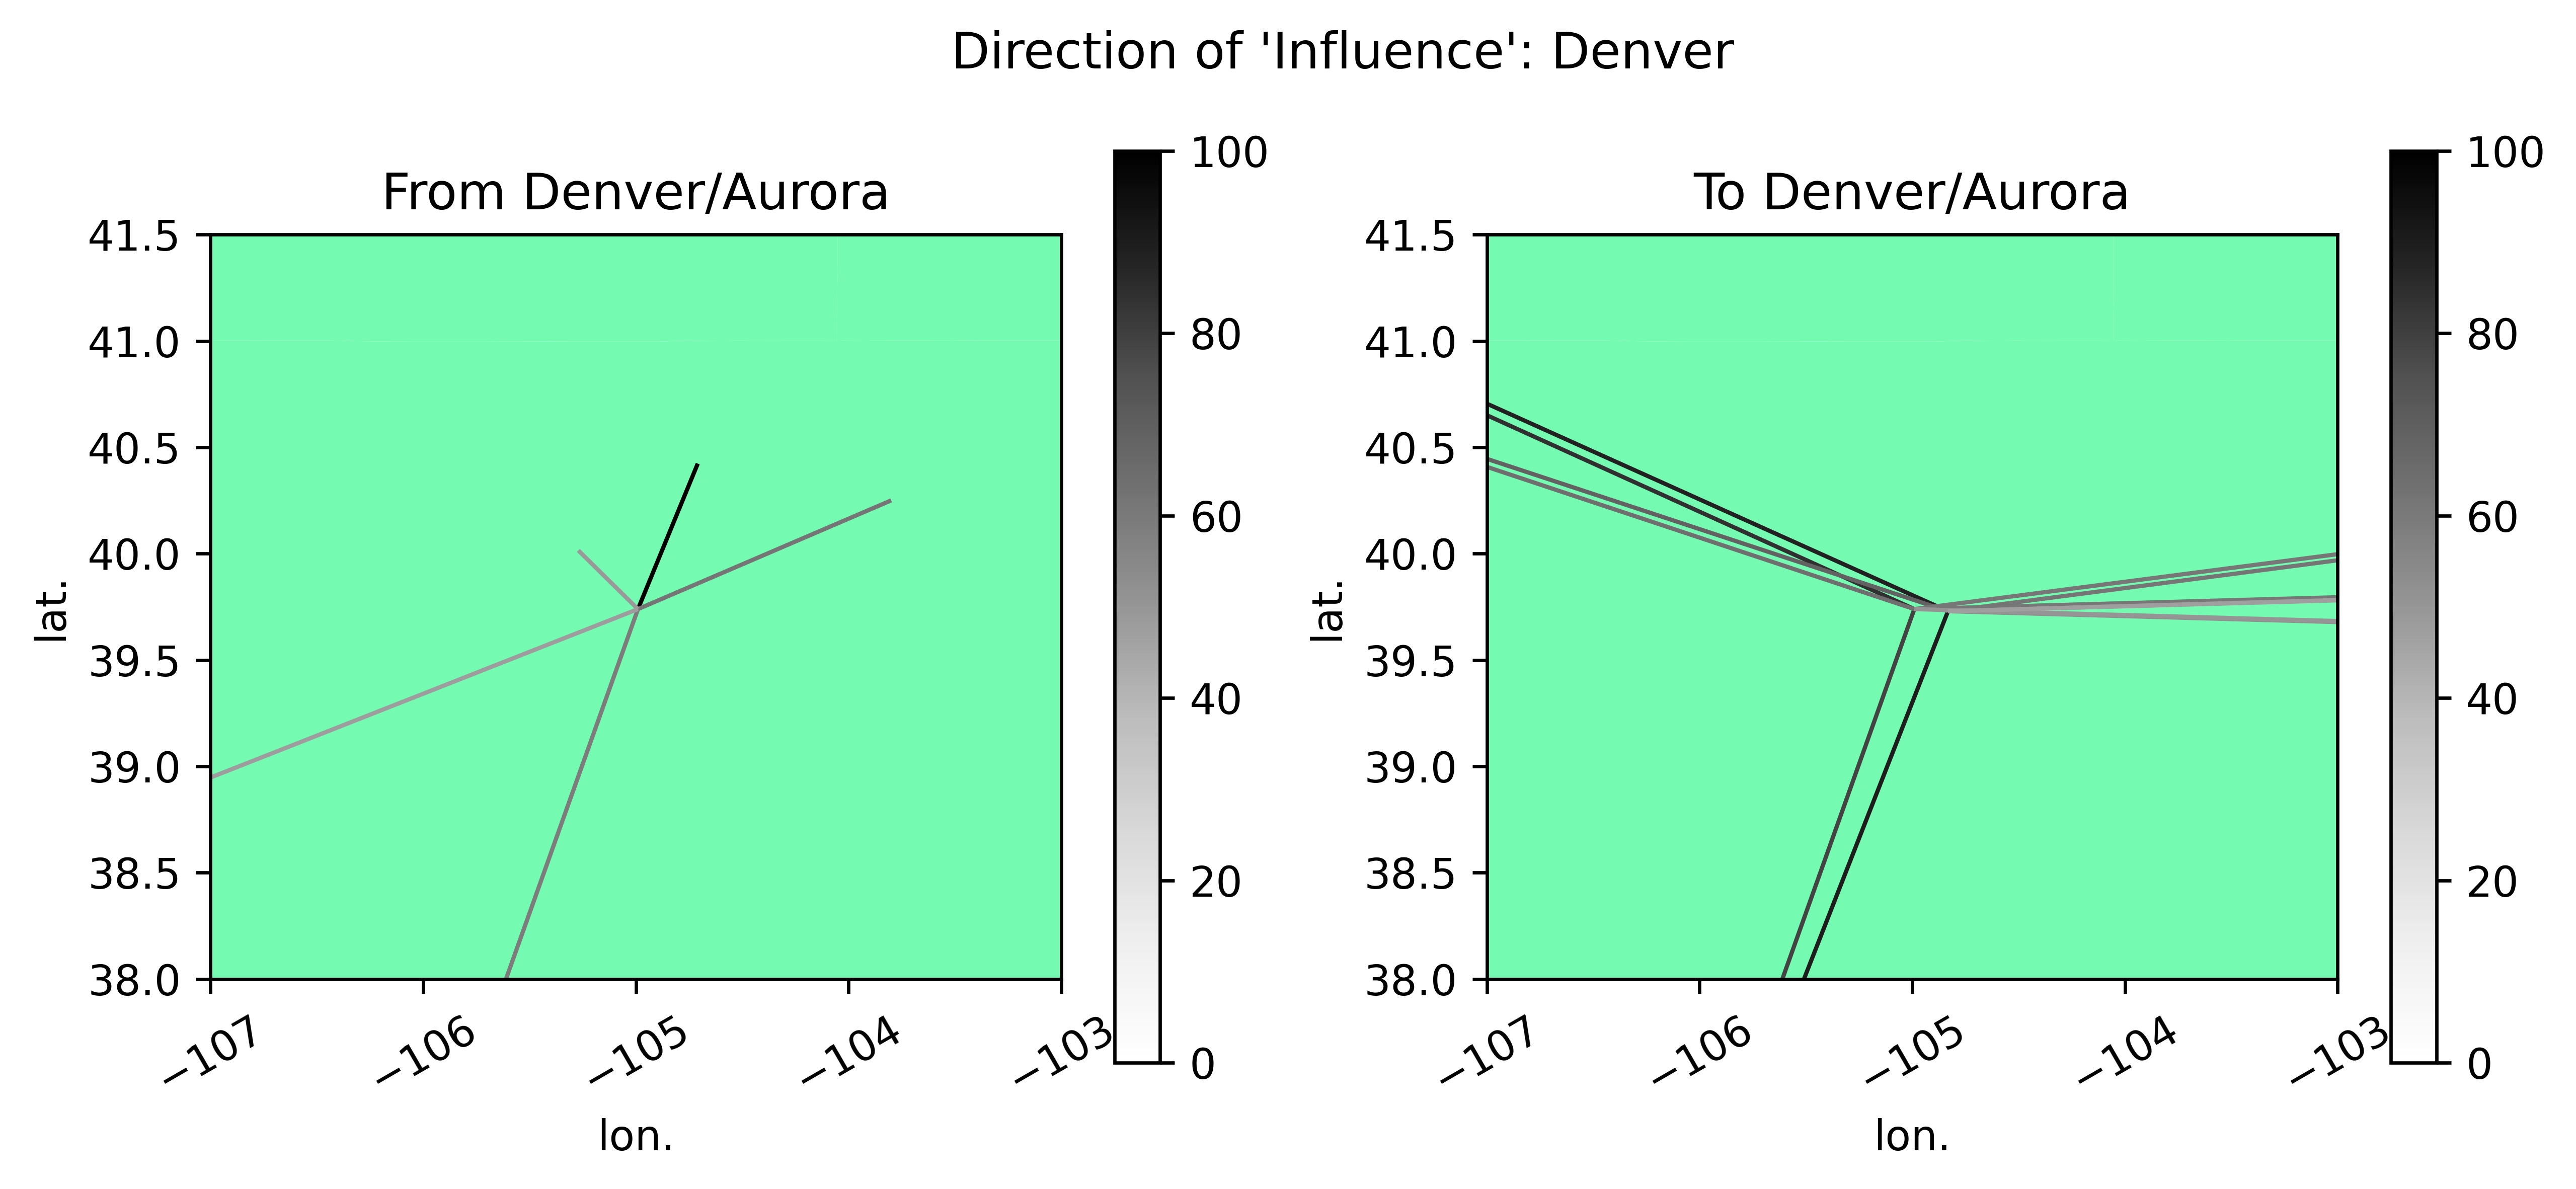

In [539]:

#first try top 200 weights
dfs = [fromDenverBoulder, toDenverBoulder]
cols = 2

fig, axs = plt.subplots(ncols=cols, figsize=(10, 4))
xlims = [[-107, -103], [-107, -103]]
ylims = [[38, 41.5], [38, 41.5]]
metroNames = ["From Denver/Aurora", "To Denver/Aurora"]

i = 0 
for k in range(cols): 
    df = dfs[i].sort_values("weight", ascending=False).head(200)
    states.plot(color="#75fab1", ax=axs[k])
    print(df["weight"])
    df.plot(ax=axs[k],alpha=1, legend=True, linewidth=1, column="weight", cmap="Greys", vmin=0, vmax=100)
    axs[k].set_xlim(xlims[i])
    axs[k].set_ylim(ylims[i])
    plt.draw()
    axs[k].set_xticks(axs[k].get_xticks())
    axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=30)
    axs[k].set_title(metroNames[i])
    axs[k].set_xlabel("lon.")
    axs[k].set_ylabel("lat.")
    
    i += 1
    #need to think about scaling for the number of articles produced? 
    #obviously small outlets aren't going to have many connections 
    #plt.title("Outlet Pairs with Over 10 Common Stories")
    #plt.xlabel("longitude")
    #plt.ylabel("latitude", rotation=0, labelpad=15)

fig.suptitle("Direction of 'Influence': Denver")

In [509]:
top200[["state1", "state2"]] = pd.DataFrame(top200["state"].apply(getFirst).tolist(), index=top200.index)

In [511]:
top200.loc[(top200["state1"] == "Colorado") | (top200["state2"] == "Colorado"), ["source", "weight"]]

source  weight
22657            (thedenverpost, greeleytribune)     177
25605        (thelamardailynews, greeleytribune)     111
6580               (dailyrecord, greeleytribune)     110
9053           (fortmorgantimes, greeleytribune)     104
591         (albuquerquejournal, aurorasentinel)      90
27512          (theseattletimes, aurorasentinel)      89
27663           (theseattletimes, thedenverpost)      84
743          (albuquerquejournal, thedenverpost)      79
22604            (thedenverpost, aurorasentinel)      74
21062             (thecolumbian, aurorasentinel)      69
21490           (thedailycamera, greeleytribune)      67
21214              (thecolumbian, thedenverpost)      64
15656   (pittsburghtribunereview, thedenverpost)      62
25326       (thekennebecjournal, aurorasentinel)      62
22650           (thedenverpost, fortmorgantimes)      62
25480        (thekennebecjournal, thedenverpost)      61
13753           (murrysvillestar, thedenverpost)      61
22598        (thedenverpost, albuquerquejournal)      59
26954              (therepublic, aurorasentinel)      52
27106               (therepublic, thedenverpost)      50
22750            (thedenverpost, thedailycamera)      49
22811           (thedenverpost, westhawaiitoday)      48
13602          (murrysvillestar, aurorasentinel)      47
9805           (greeleytribune, fortmorgantimes)      47
15505  (pittsburghtribunereview, aurorasentinel)      47

### Doesn't really work to use weighted edges... 

(20.0, 50.0)

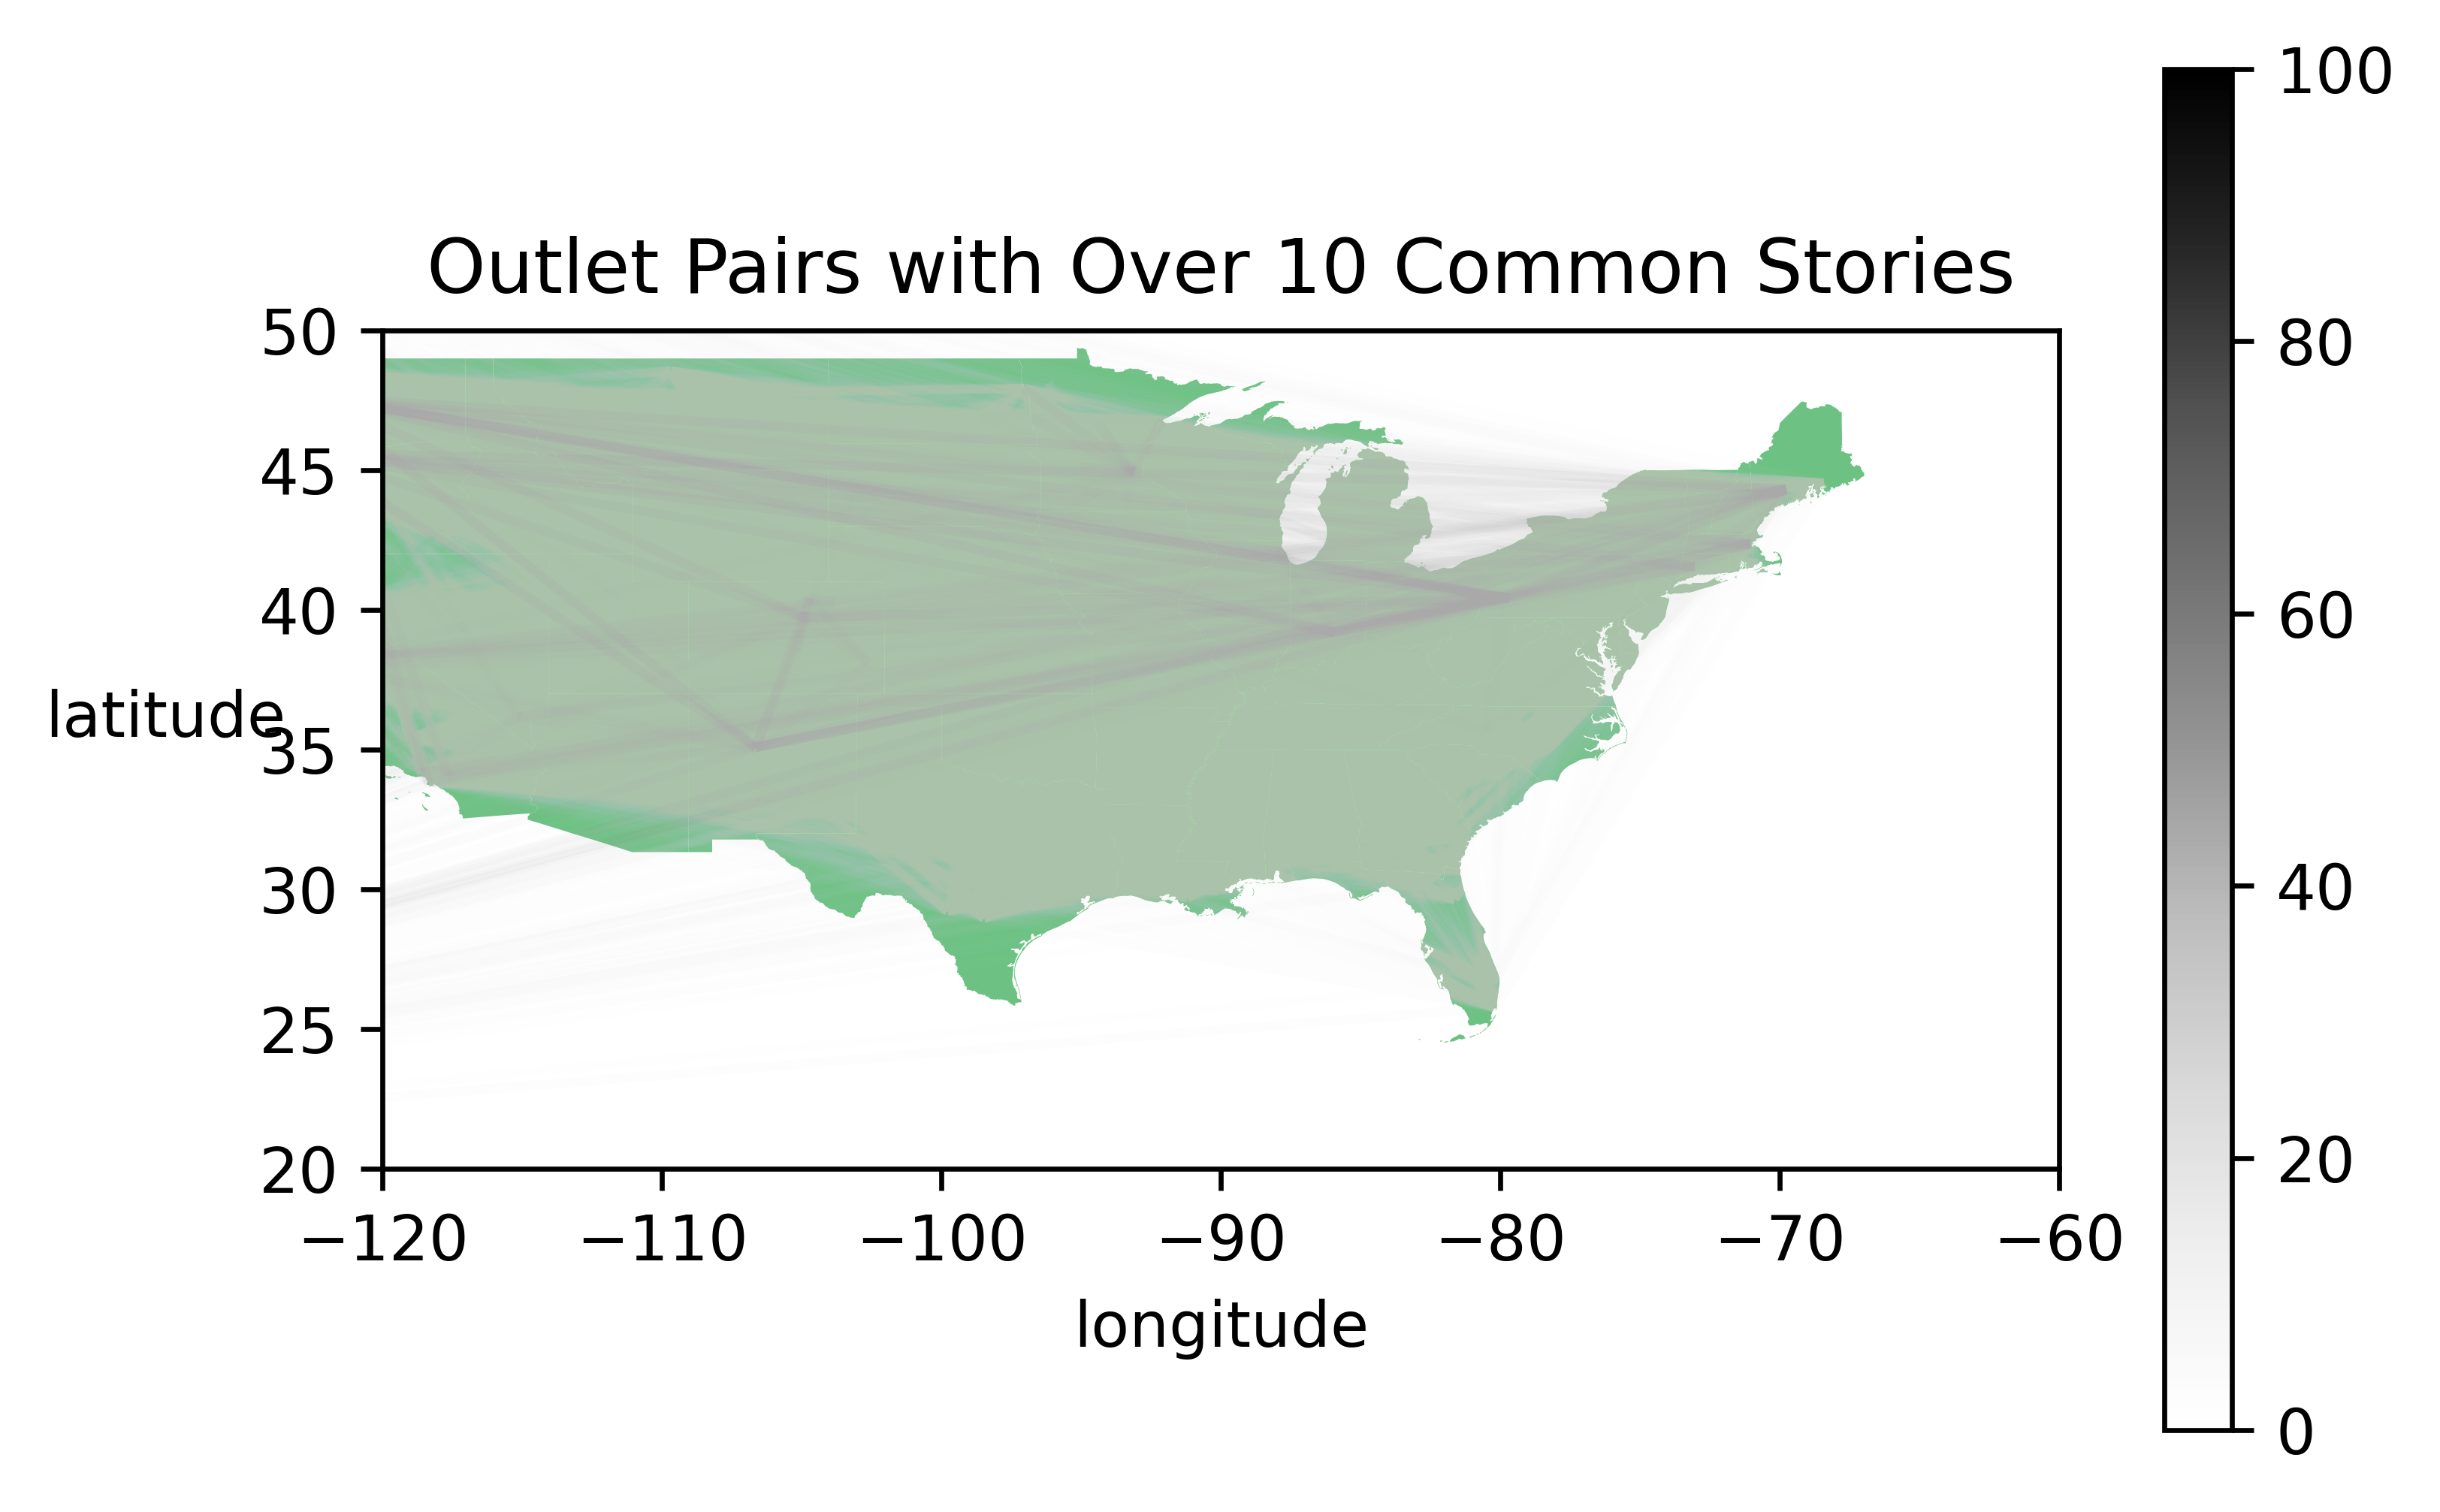

In [433]:
localEdgesGdf.plot(ax=states.plot(figsize=(6, 4), color="#6dc283"), column="weight", alpha=.01, legend=True, cmap="Greys", vmin=0, vmax=100)
#need to think about scaling for the number of articles produced? 
#obviously small outlets aren't going to have many connections 
plt.title("Outlet Pairs with Over 10 Common Stories")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-120, -60])
plt.ylim([20, 50])

In [544]:
#the dataframe with the outlets needed to make our networkx graph 
outletEdges.head(3)

article_id  \
source                                                                                   
(abcnews, addisoncountyindependent)  [(nan, addisoncountyindependent--2021-07-29--V...   
(abcnews, advertiserdemocrat)        [(nan, advertiserdemocrat--2021-06-23--Movie R...   
(abcnews, alamedatimesstar)          [(nan, alamedatimesstar--2021-05-03--Bay Area ...   

                                                                       sourcedomain_id  \
source                                                                                   
(abcnews, addisoncountyindependent)  [(nan, addisoncountyindependent-addisonindepen...   
(abcnews, advertiserdemocrat)               [(nan, advertiserdemocrat-sunjournal.com)]   
(abcnews, alamedatimesstar)          [(nan, alamedatimesstar-eastbaytimes.com), (na...   

                                                                                  date  \
source                                                                                   
(abcnews, addisoncountyindependent)       [(2021-05-01 00:00:00, 2021-07-29 00:00:00)]   
(abcnews, advertiserdemocrat)             [(2021-06-20 00:00:00, 2021-06-23 00:00:00)]   
(abcnews, alamedatimesstar)          [(2021-05-01 00:00:00, 2021-05-03 00:00:00), (...   

                                                                                 title  \
source                                                                                   
(abcnews, addisoncountyindependent)  [(Prosecutors seek higher sentence for Chauvin...   
(abcnews, advertiserdemocrat)        [(‘The Hitman’s Wife’s Bodyguard’ hits top mar...   
(abcnews, alamedatimesstar)          [(Prosecutors seek higher sentence for Chauvin...   

                                                                                 url_x  \
source                                                                                   
(abcnews, addisoncountyindependent)  [(nan, https://addisonindependent.com/news/ver...   
(abcnews, advertiserdemocrat)        [(nan, https://www.sunjournal.com/2021/06/23/m...   
(abcnews, alamedatimesstar)          [(nan, https://www.eastbaytimes.com/2021/05/03...   

                                                                                  fips  \
source                                                                                   
(abcnews, addisoncountyindependent)                                   [(nan, 50001.0)]   
(abcnews, advertiserdemocrat)                                         [(nan, 23017.0)]   
(abcnews, alamedatimesstar)          [(nan, 6001.0), (nan, 6001.0), (nan, 6001.0), ...   

                                                                           description  \
source                                                                                   
(abcnews, addisoncountyindependent)  [(nan, Bi-weekly newspaper distributed in the ...   
(abcnews, advertiserdemocrat)        [(nan, Provides national, regional, and local ...   
(abcnews, alamedatimesstar)          [(nan, A daily newspaper with a full range of ...   

                                                                           onlinesince  \
source                                                                                   
(abcnews, addisoncountyindependent)                               [(nan, 12-Jan-1997)]   
(abcnews, advertiserdemocrat)                                     [(nan, 03-Mar-1997)]   
(abcnews, alamedatimesstar)          [(nan, None), (nan, None), (nan, None), (nan, ...   

                                                                                  rank  \
source                                                                                   
(abcnews, addisoncountyindependent)                                   [(nan, 1011377)]   
(abcnews, advertiserdemocrat)                                          [(nan, 201689)]   
(abcnews, alamedatimesstar)          [(nan, 53056), (nan, 53056), (nan, 53056), (na...   

                 

In [558]:
graphDf = outletEdges.reset_index()
graphDf[["source1", "source2"]] = pd.DataFrame(graphDf["source"].tolist(), index=graphDf.index)

In [554]:
#generate a configuration model/random graph with the same edge distribution 
weights = graphDf["weight"]

0         1
1         1
2         5
3         3
4        14
         ..
37240     1
37241     1
37242     1
37243     1
37244     1
Name: weight, Length: 37245, dtype: int64

In [680]:
#right now we don't have parallel edges but we want to! 

graphDf[["weight", "source1", "source2"]]

weight            source1                       source2
0           1            abcnews      addisoncountyindependent
1           1            abcnews            advertiserdemocrat
2           5            abcnews              alamedatimesstar
3           3            abcnews       alaskajournalofcommerce
4          14            abcnews              albertleatribune
...       ...                ...                           ...
37240       1  yellowspringsnews                   thewanderer
37241       1  yellowspringsnews      vancouverbusinessjournal
37242       1  yellowspringsnews  vashonmauryislandbeachcomber
37243       1  yellowspringsnews                 vicksburgpost
37244       1  yellowspringsnews              whidbeynewstimes

[37245 rows x 3 columns]

In [714]:
multigraphDf = pairwise.copy(deep=True)
multigraphDf[["source1", "source2"]] = pd.DataFrame(multigraphDf["source"].tolist(), index=multigraphDf.index)

#create graph from pandas dataframe 
outletGraph = nx.from_pandas_edgelist(multigraphDf[["source1", "source2"]], source="source1", target="source2", create_using=nx.MultiDiGraph)

In [717]:
#add node attributes (i.e. population etc... ) to nodes that represent local outlets 
onlyLocal = merged[merged["national"] == False].drop_duplicates(subset="source") 

#get national/local 
#CHECKED that this works correctly 
localNatDict = merged[["source", "national"]].drop_duplicates().set_index("source").to_dict(orient="index")
nx.set_node_attributes(outletGraph, localNatDict)


## Test for local <-> national dynamics 

In [835]:
localNatList = []
natLocalList = []
localLocalList = []
natNatList = []
for i in tqdm(range(200)):
    #create config model 
    #the config model creates a graph with the number of in and out degrees that we see in our graph 
    #the nodes are random though, so we are assuming that there is no relationship between 
    #any node characteristics and their degrees 
    inDegree = [tup[1] for tup in outletGraph.in_degree()]
    outDegree = [tup[1] for tup in outletGraph.out_degree()]
    configModel = nx.directed_configuration_model(inDegree, outDegree)

    #NOTE: we have a different number of edges now so we will need to scale by that! 
    configModel.remove_edges_from(nx.selfloop_edges(configModel))

    #set the config model to have the same nodes and attributes as the original model 
    nodeMapping = dict(zip(list(configModel.nodes()), list(outletGraph.nodes())))
    configModel = nx.relabel_nodes(configModel, nodeMapping)
    nx.set_node_attributes(configModel, localNatDict)

    edgeDf = nx.to_pandas_edgelist(configModel)
    localNatDf = merged[["source", "national"]].drop_duplicates()
    temp = pd.merge(edgeDf, localNatDf, how="right", on="source").rename(columns={"national":"national1"})
    localNatDf = localNatDf.rename(columns={"source":"target"})
    edgeDf = pd.merge(temp, localNatDf, how="right", on="target").rename(columns={"national":"national2"})
    #merged["greaterPop"] = merged[merged]

    totalEdges = len(list(configModel.edges()))
    localNatProp = len(edgeDf.loc[(edgeDf["national1"] == False) & (edgeDf["national2"] == True)]) / totalEdges
    natLocalProp = len(edgeDf.loc[(edgeDf["national1"] == True) & (edgeDf["national2"] == False)]) / totalEdges
    localLocalProp = len(edgeDf.loc[(edgeDf["national1"] == False) & (edgeDf["national2"] == False)]) / totalEdges 
    natNatProp = len(edgeDf.loc[(edgeDf["national1"] == True) & (edgeDf["national2"] == True)]) / totalEdges
                                    
    localNatList.append(localNatProp*100)
    natLocalList.append(natLocalProp*100)
    localLocalList.append(localLocalProp*100)
    natNatList.append(natNatProp*100)

  0%|          | 1/200 [00:03<13:01,  3.93s/it]


KeyboardInterrupt: 

In [780]:
# get the observed percentages of edge types 
edgeDf = nx.to_pandas_edgelist(outletGraph)
localNatDf = merged[["source", "national"]].drop_duplicates()
temp = pd.merge(edgeDf, localNatDf, how="right", on="source").rename(columns={"national":"national1"})
localNatDf = localNatDf.rename(columns={"source":"target"})
edgeDf = pd.merge(temp, localNatDf, how="right", on="target").rename(columns={"national":"national2"})

totalEdges = len(list(outletGraph.edges()))
obs_localNatProp = len(edgeDf.loc[(edgeDf["national1"] == False) & (edgeDf["national2"] == True)]) / totalEdges
obs_natLocalProp = len(edgeDf.loc[(edgeDf["national1"] == True) & (edgeDf["national2"] == False)]) / totalEdges
obs_localLocalProp = len(edgeDf.loc[(edgeDf["national1"] == False) & (edgeDf["national2"] == False)]) / totalEdges
obs_natNatProp = len(edgeDf.loc[(edgeDf["national1"] == True) & (edgeDf["national2"] == True)]) / totalEdges

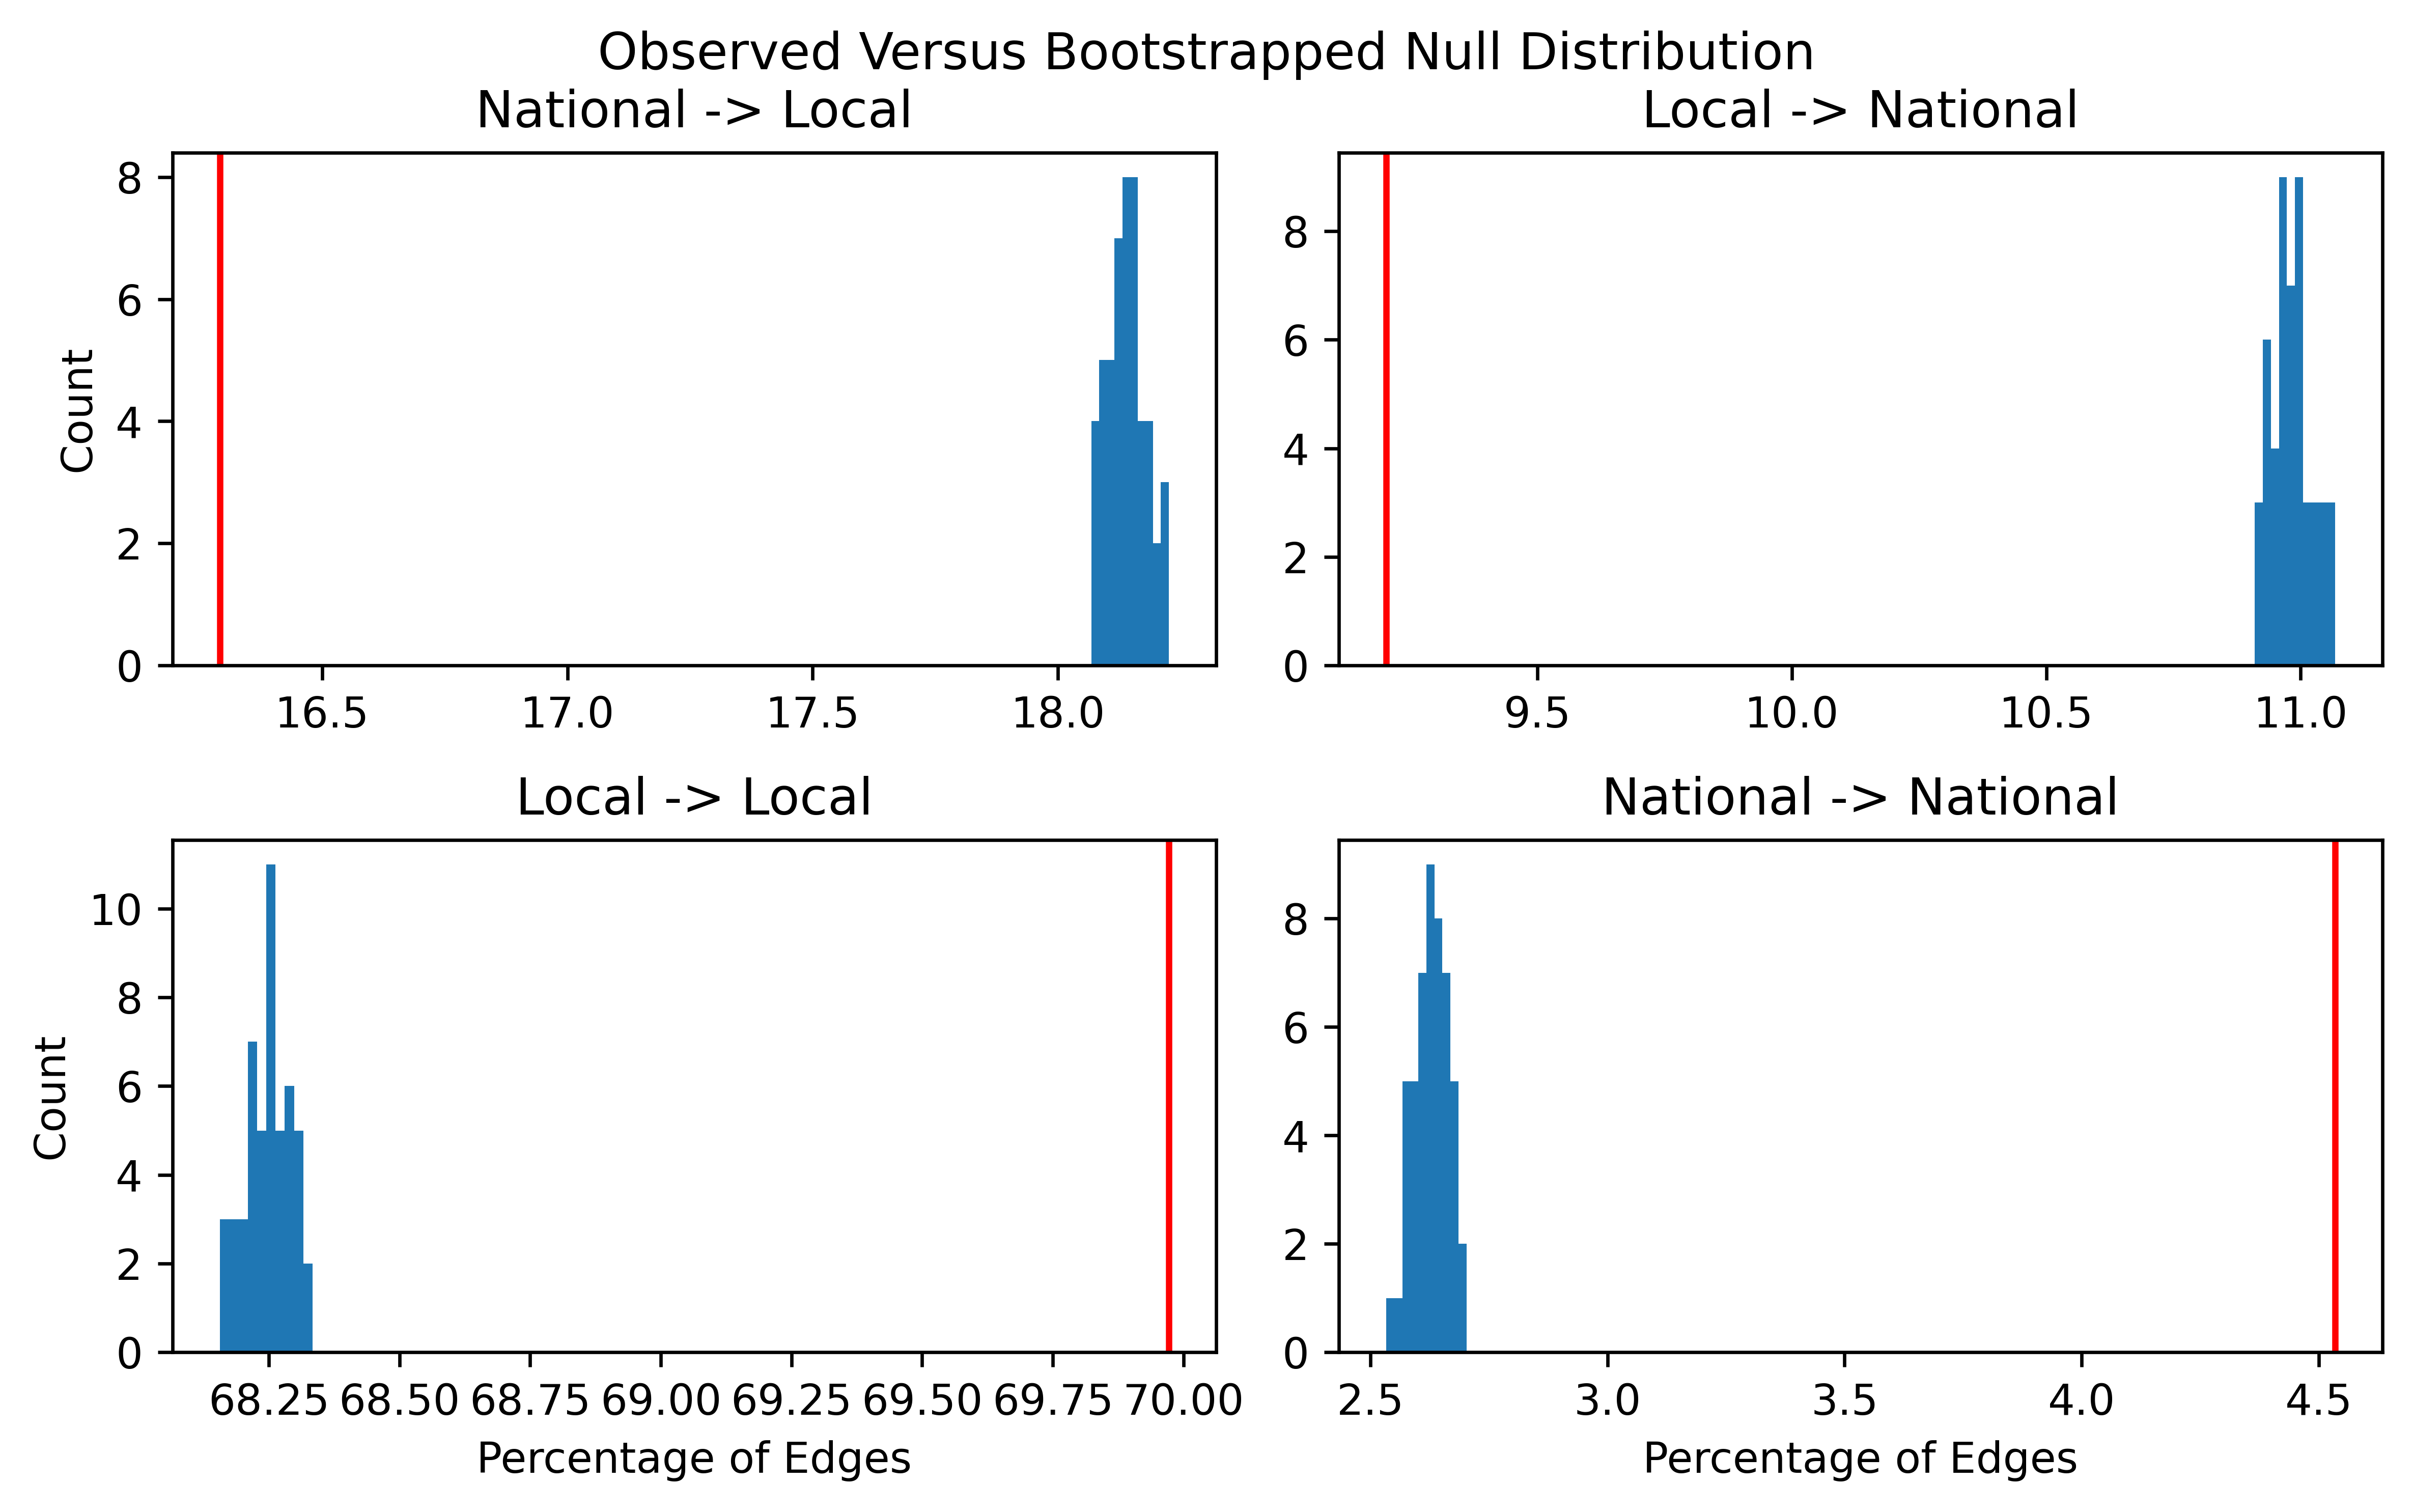

In [796]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(8, 5))
axs[0, 0].hist(natLocalList)
axs[0, 0].axvline(obs_natLocalProp*100, color="red")
axs[0, 0].set_title("National -> Local")
axs[0, 0].set_ylabel("Count")

axs[0, 1].hist(localNatList)
axs[0, 1].set_title("Local -> National")
axs[0, 1].axvline(obs_localNatProp*100, color="red")


axs[1, 0].hist(localLocalList)
axs[1, 0].set_title("Local -> Local")
axs[1, 0].axvline(obs_localLocalProp*100, color="red")
axs[1, 0].set_xlabel("Percentage of Edges")
axs[1, 0].set_ylabel("Count")

axs[1, 1].hist(natNatList)
axs[1, 1].set_title("National -> National")
axs[1, 1].axvline(obs_natNatProp*100, color="red")
axs[1, 1].set_xlabel("Percentage of Edges")
fig.tight_layout()
fig.suptitle("Observed Versus Bootstrapped Null Distribution")
plt.subplots_adjust(top=0.9)

## Looking at population among local outlets 

In [857]:
localPairs = pairwise.copy(deep=True)
localPairs[["national1", "national2"]] = pd.DataFrame(localPairs["national"].tolist(), index=localPairs.index)
localPairs = localPairs.loc[(localPairs["national1"] == False) & (localPairs["national2"] == False)]
localPairs[["source1", "source2"]] = pd.DataFrame(localPairs["source"].tolist(), index=localPairs.index)

#create graph from pandas dataframe 
localGraph = nx.from_pandas_edgelist(localPairs[["source1", "source2"]], source="source1", target="source2", create_using=nx.MultiDiGraph)

In [859]:
#add node attributes (i.e. population etc... ) to nodes that represent local outlets 
localDemographics = merged[merged["national"] == False].drop_duplicates(subset="source") 

#get national/local 
#CHECKED that this works correctly 
populationDict = localDemographics[["source", "total_population", "lat", "lon"]].drop_duplicates().set_index("source").to_dict(orient="index")
nx.set_node_attributes(localGraph, populationDict)

In [ ]:
def euclidDist(inList):
    iLat1, iLat2, iLon1, iLon2 = inList
    point1 = np.array([iLat1, iLon1])
    point2 = np.array([iLat2, iLon2])
    return np.linalg.norm(point1 - point2)

In [882]:
#now we bootstrap the distribution
greatLessList = []
lessGreatList = []
sameList = []
medianLatLonList = []

inDegree = [tup[1] for tup in localGraph.in_degree()]
outDegree = [tup[1] for tup in localGraph.out_degree()]
    
for i in tqdm(range(100)):
    #create config model 
    #the config model creates a graph with the number of in and out degrees that we see in our graph 
    #the nodes are random though, so we are assuming that there is no relationship between 
    #any node characteristics and their degrees 
    configModel = nx.directed_configuration_model(inDegree, outDegree)

    #NOTE: we have a different number of edges now so we will need to scale by that! 
    configModel.remove_edges_from(nx.selfloop_edges(configModel))

    #set the config model to have the same nodes and attributes as the original model 
    nodeMappings = dict(zip(list(configModel.nodes()), list(localGraph.nodes())))
    configModel = nx.relabel_nodes(configModel, nodeMapping)
    nx.set_node_attributes(configModel, populationDict)

    edgeDf = nx.to_pandas_edgelist(configModel)
    popDf = localDemographics[["source", "total_population", "lat", "lon"]].drop_duplicates()
    temp = pd.merge(edgeDf, popDf, how="inner", on="source").rename(columns={"total_population":"total_population1", "lat":"lat1", "lon":"lon1"})

    popDf = popDf.rename(columns={"source":"target"})
    edgeDf = pd.merge(temp, popDf, how="inner", on="target").rename(columns={"total_population":"total_population2", "lat":"lat2", "lon":"lon2"})
    #merged["greaterPop"] = merged[merged]

    totalEdges = len(list(configModel.edges()))

    #"influence" from more to less populous 
    greatLessProp = len(edgeDf.loc[edgeDf["total_population1"] > edgeDf["total_population2"]]) / totalEdges

    #"influence" from less to more populous 
    lessGreatProp = len(edgeDf.loc[edgeDf["total_population1"] < edgeDf["total_population2"]]) / totalEdges

    #"influence" within same population. Likely the same county 
    sameProp =  len(edgeDf.loc[edgeDf["total_population1"] == edgeDf["total_population2"]]) / totalEdges

    greatLessList.append(greatLessProp*100)
    lessGreatList.append(lessGreatProp*100)
    sameList.append(sameProp*100)

    #for distance comparison 
    latLonNorms = [euclidDist(item) for item in list(zip(edgeDf["lat1"], edgeDf["lat2"], edgeDf["lon1"], edgeDf["lon2"]))]
    latLonMedian = np.median(latLonNorms)

    medianLatLonList.append(latLonMedian)

100%|██████████| 100/100 [07:36<00:00,  4.57s/it]


In [883]:
#same thing but use our observed, local graph as our edgeDf 
edgeDf = nx.to_pandas_edgelist(localGraph)
popDf = localDemographics[["source", "total_population", "lat", "lon"]].drop_duplicates()
temp = pd.merge(edgeDf, popDf, how="inner", on="source").rename(columns={"total_population":"total_population1", "lat":"lat1", "lon":"lon1"})

popDf = popDf.rename(columns={"source":"target"})
edgeDf = pd.merge(temp, popDf, how="inner", on="target").rename(columns={"total_population":"total_population2", "lat":"lat2", "lon":"lon2"})
#merged["greaterPop"] = merged[merged]

totalEdges = len(list(localGraph.edges()))

#"influence" from more to less populous 
obs_greatLessProp = len(edgeDf.loc[edgeDf["total_population1"] > edgeDf["total_population2"]]) / totalEdges

#"influence" from less to more populous 
obs_lessGreatProp = len(edgeDf.loc[edgeDf["total_population1"] < edgeDf["total_population2"]]) / totalEdges

#"influence" within same population. Likely the same county 
obs_sameProp =  len(edgeDf.loc[edgeDf["total_population1"] == edgeDf["total_population2"]]) / totalEdges

#now get observed median distance 
obs_latLonNorms = [euclidDist(item) for item in list(zip(edgeDf["lat1"], edgeDf["lat2"], edgeDf["lon1"], edgeDf["lon2"]))]
obs_latLonMedian = np.median(obs_latLonNorms)


In [884]:
#so the config model has about 1,000 self edges it seems 
len(list(configModel.edges()))

106430

In [885]:
len(list(localGraph.edges()))

107452

In [886]:
localPairs[["pop1", "pop2"]] = pd.DataFrame(localPairs["total_population"].tolist(), index=localPairs.index)

In [887]:
len(localPairs[localPairs["pop1"] == localPairs["pop2"]])

1046

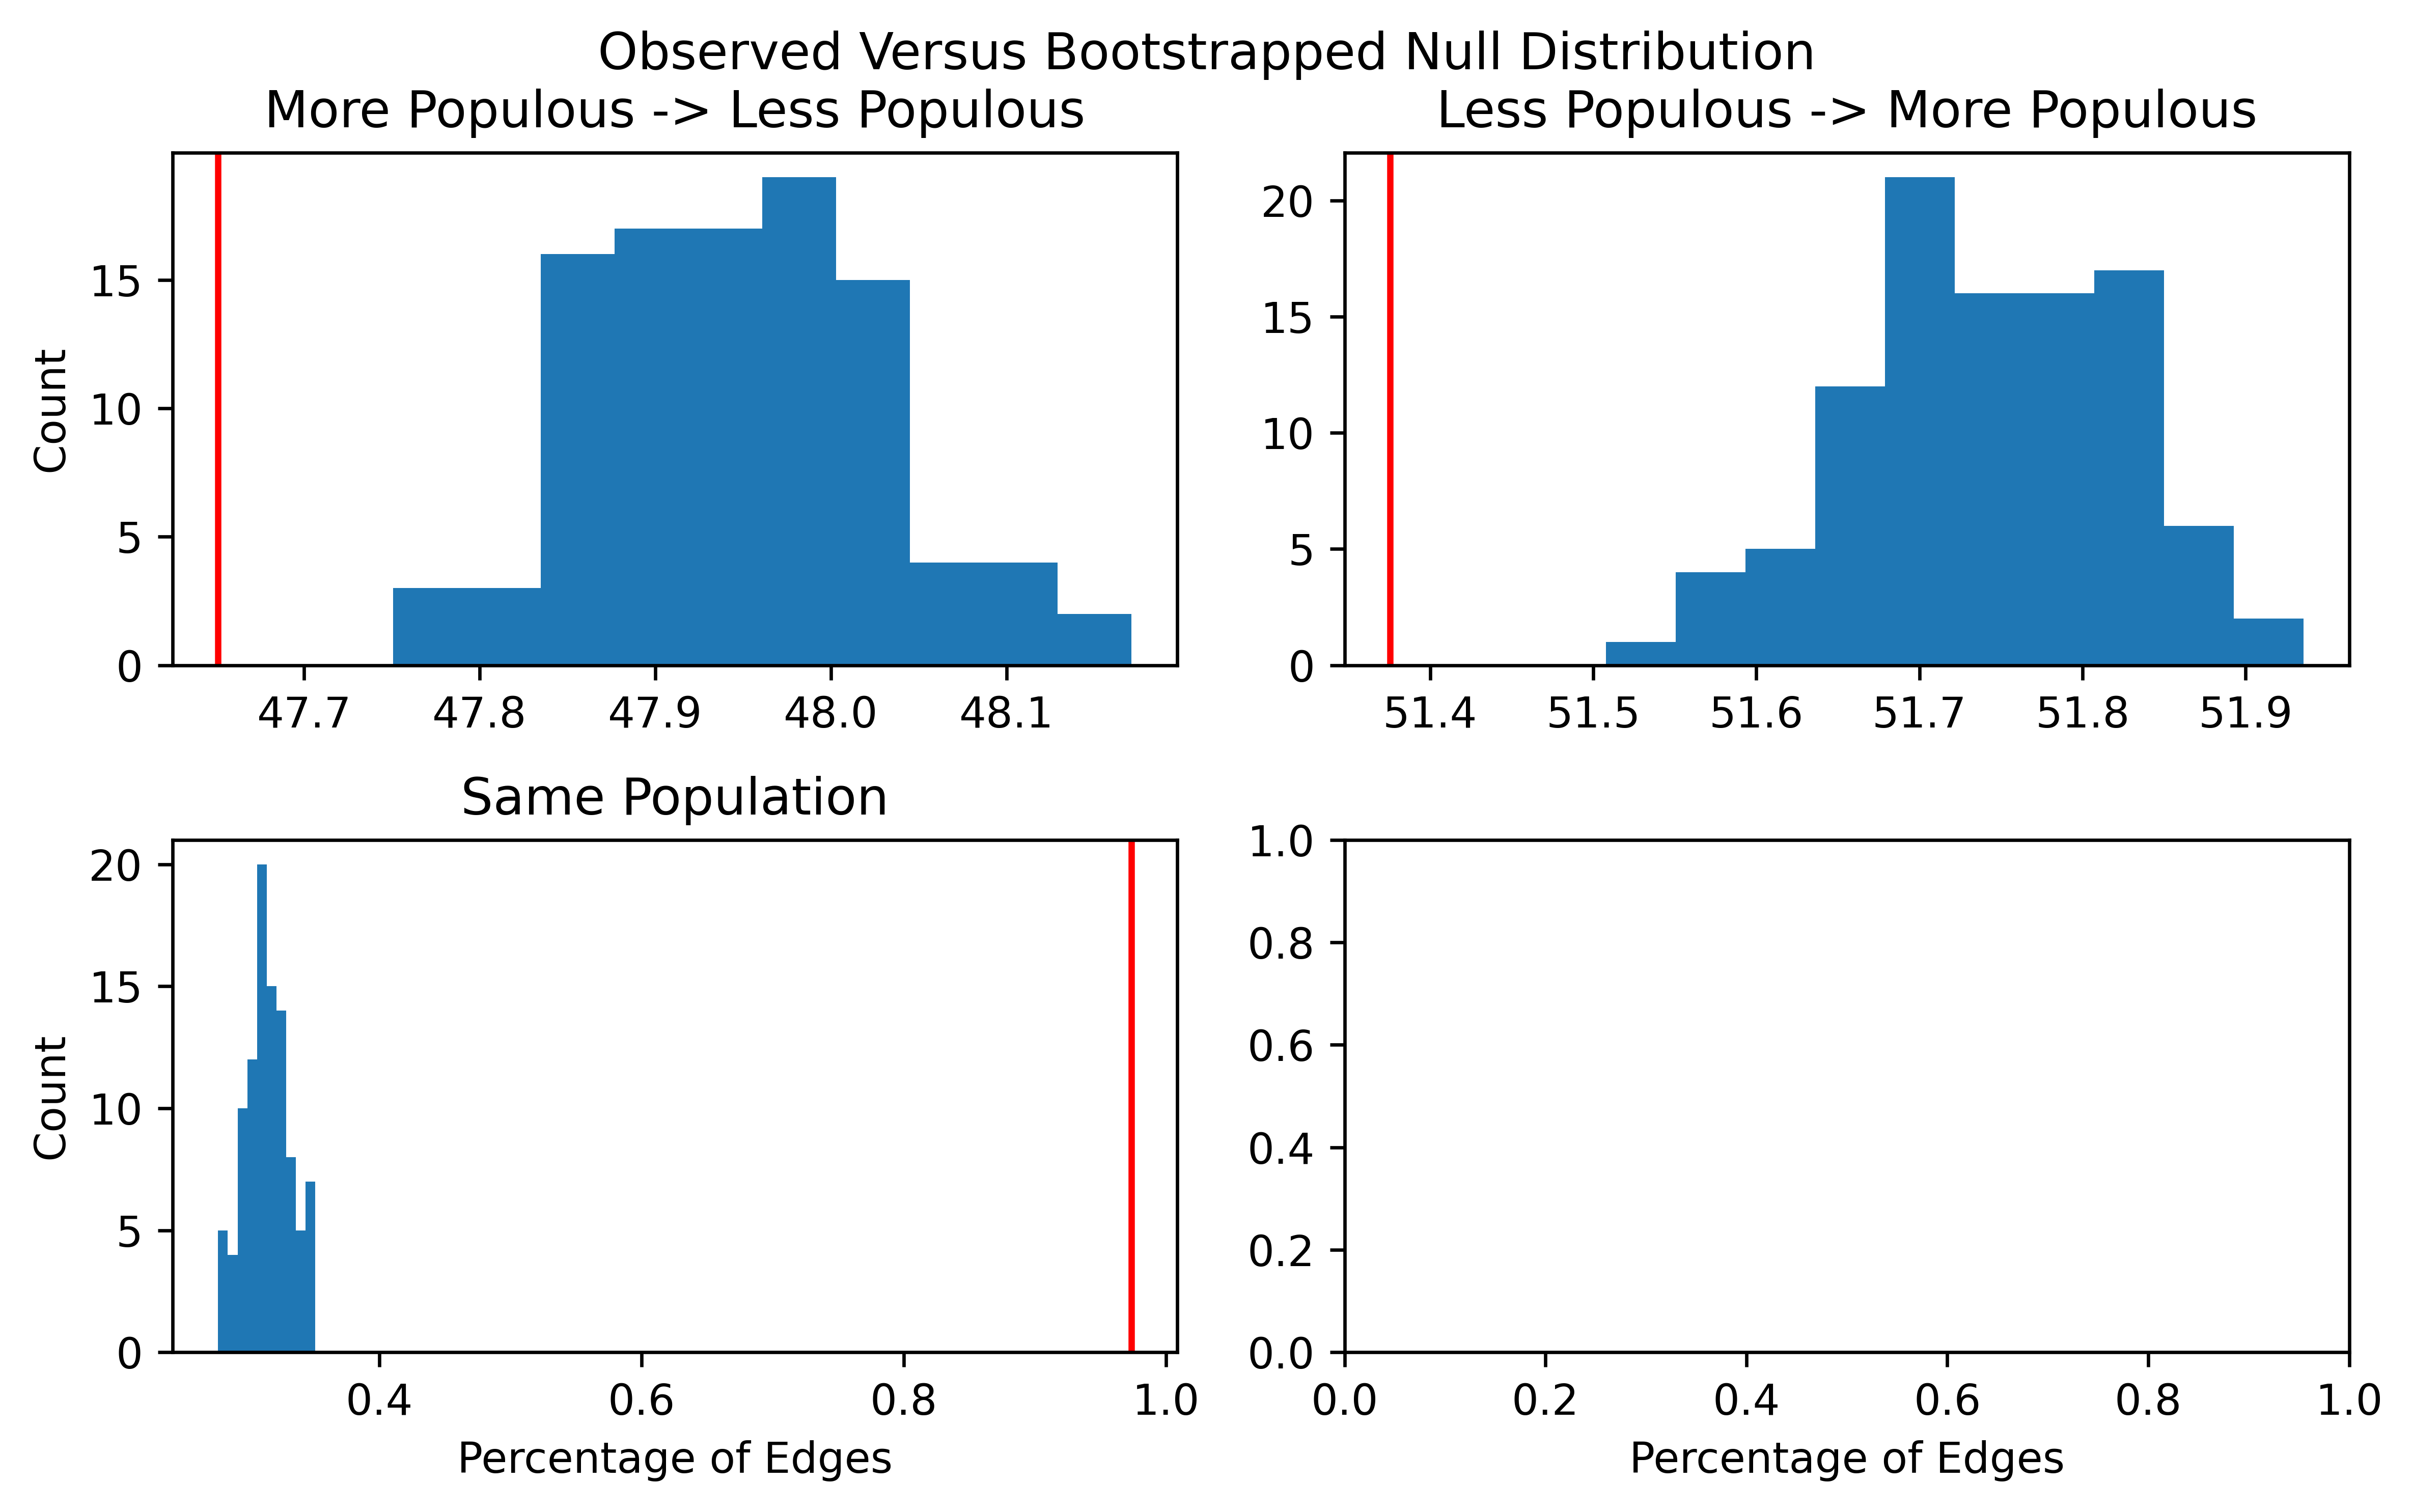

In [888]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(8, 5))
axs[0, 0].hist(greatLessList)
axs[0, 0].axvline(obs_greatLessProp*100, color="red")
axs[0, 0].set_title("More Populous -> Less Populous")
axs[0, 0].set_ylabel("Count")

axs[0, 1].hist(lessGreatList)
axs[0, 1].set_title("Less Populous -> More Populous")
axs[0, 1].axvline(obs_lessGreatProp*100, color="red")

axs[1, 0].hist(sameList)
axs[1, 0].set_title("Same Population")
axs[1, 0].axvline(obs_sameProp*100, color="red")
axs[1, 0].set_xlabel("Percentage of Edges")
axs[1, 0].set_ylabel("Count")

axs[1, 1].set_xlabel("Percentage of Edges")

fig.tight_layout()
fig.suptitle("Observed Versus Bootstrapped Null Distribution")
plt.subplots_adjust(top=0.9)

Text(0, 0.5, 'Count')

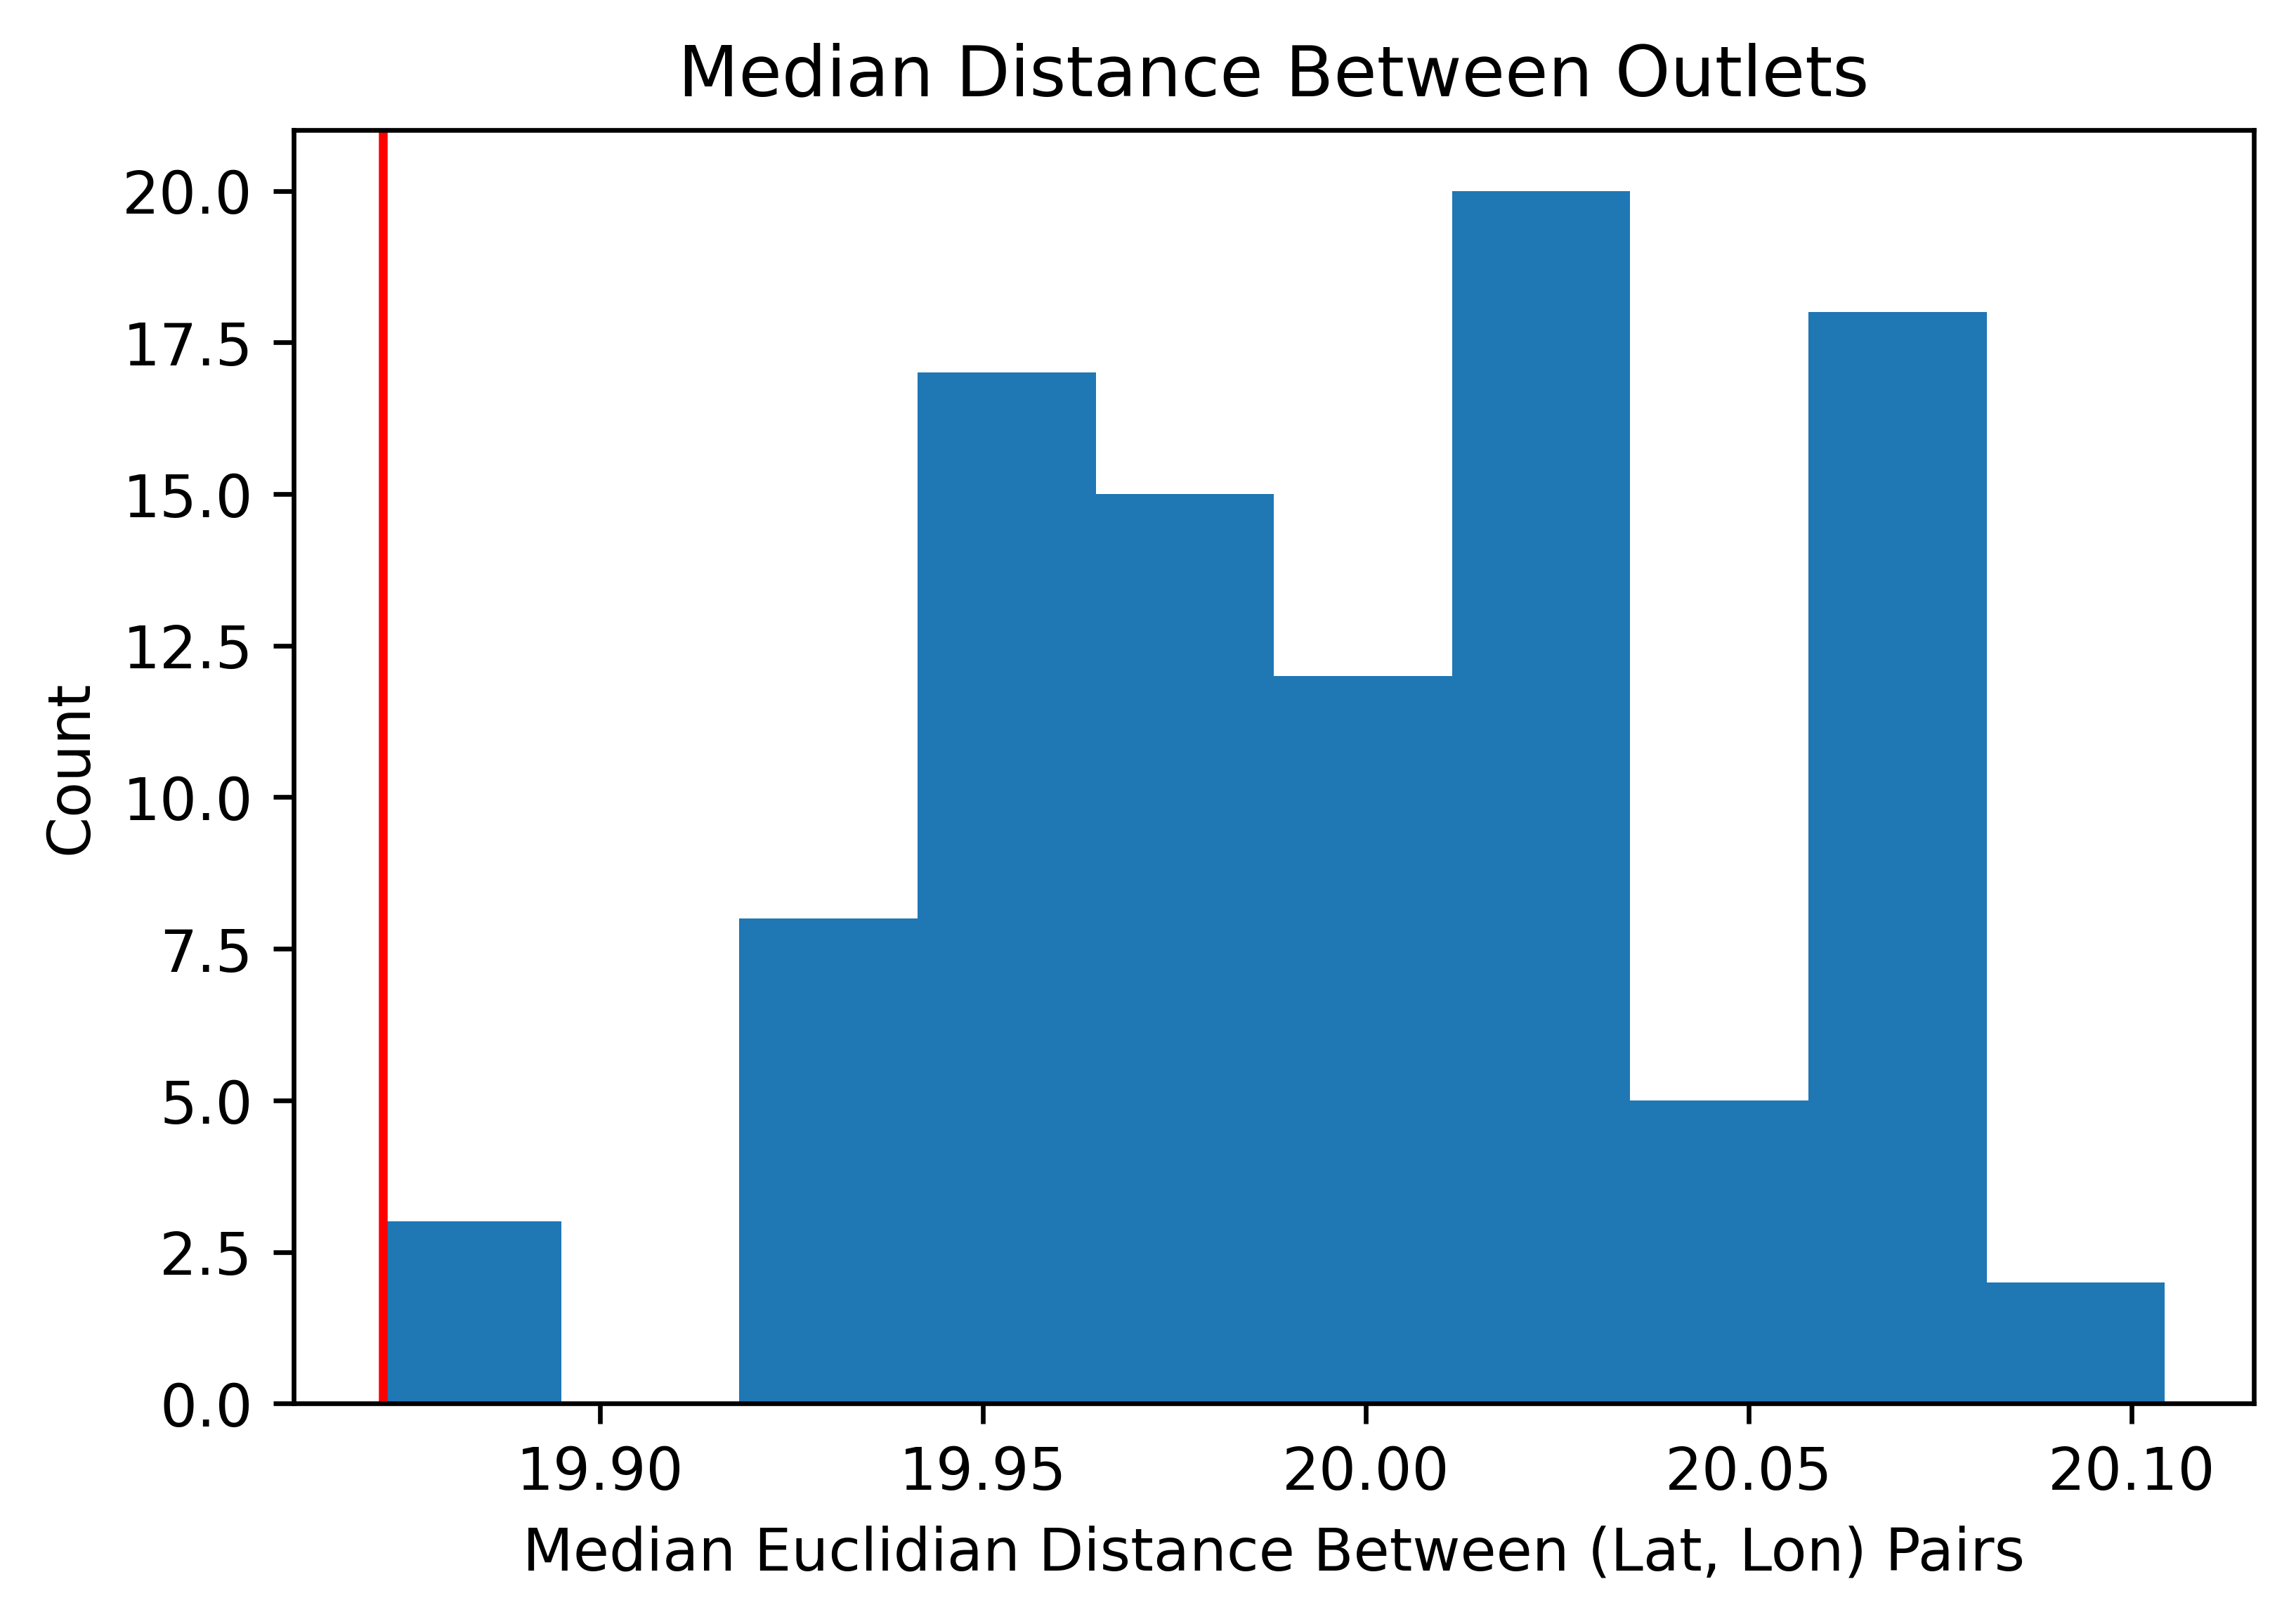

In [890]:
#now looking at median distance 
plt.hist(medianLatLonList)
plt.axvline(latLonMedian, color="red")
plt.title("Median Distance Between Outlets")
plt.xlabel("Median Euclidian Distance Between (Lat, Lon) Pairs")
plt.ylabel("Count")

Text(0.5, 0.98, 'Node Degree Distributions')

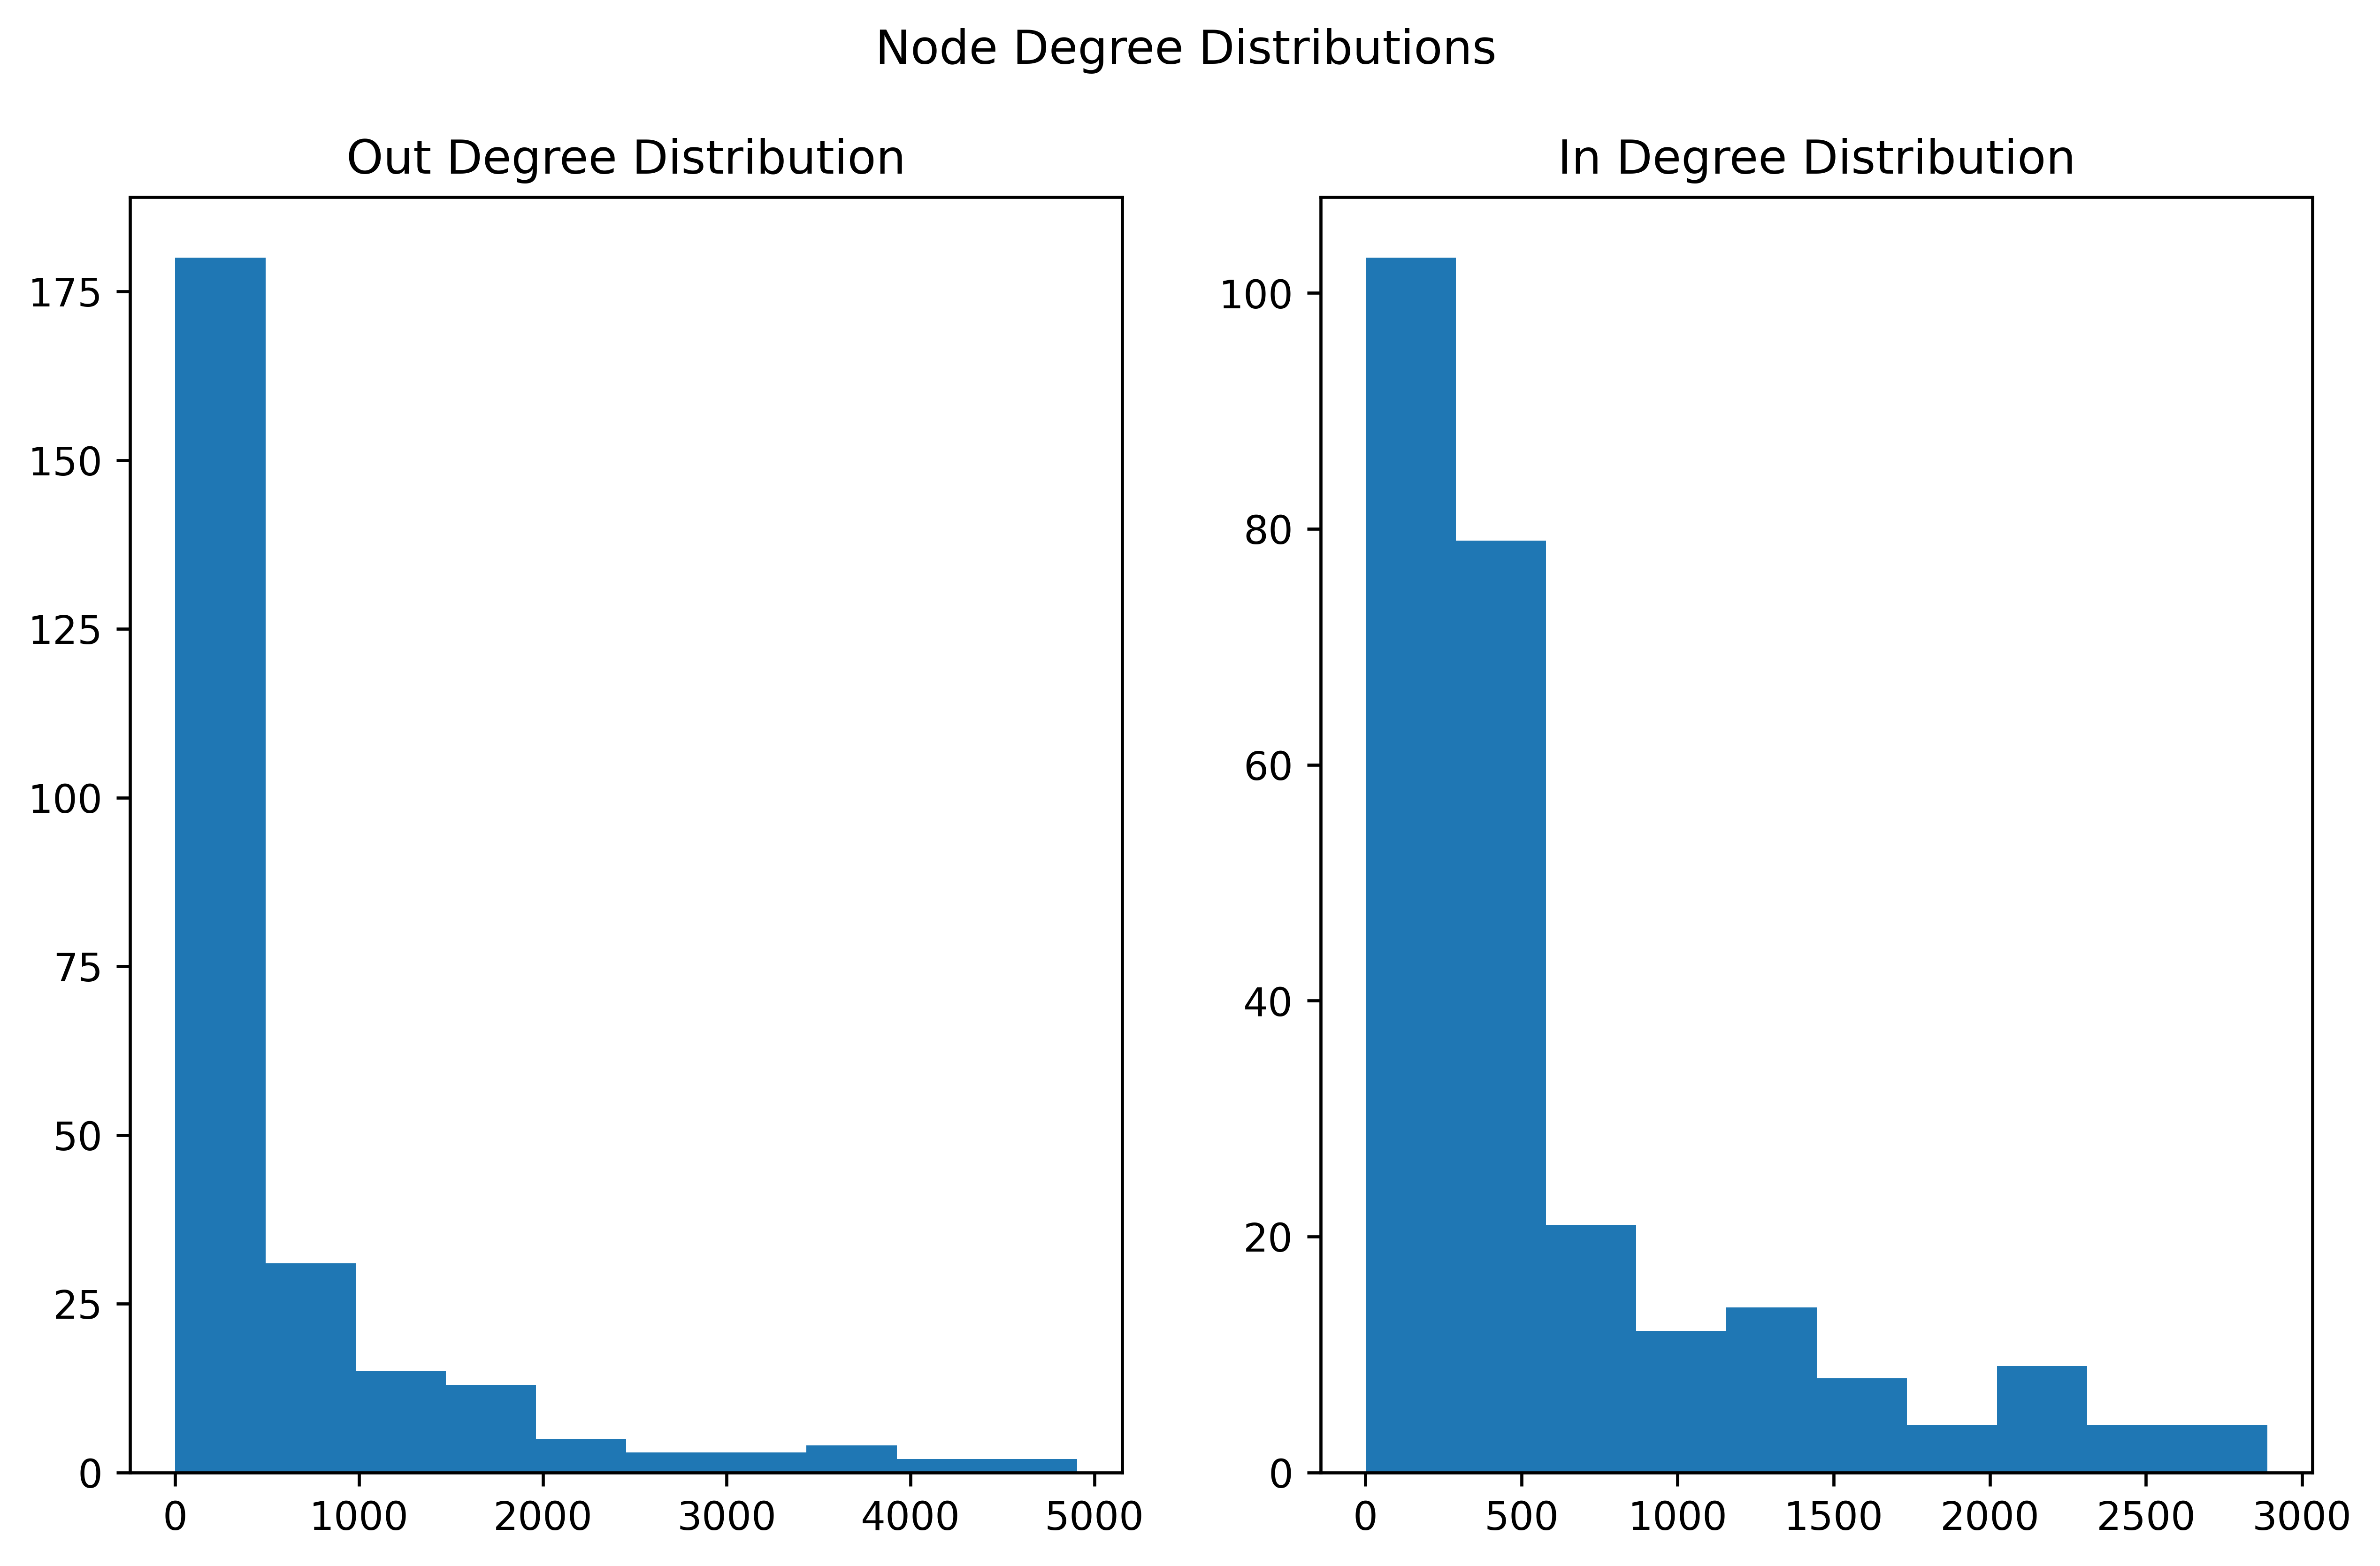

In [797]:
#plot in and out degree across our nodes 
outDegree = [tup[1] for tup in outletGraph.out_degree()]
inDegree = [tup[1] for tup in outletGraph.in_degree()]

fig, axs = plt.subplots(ncols=2, figsize = [10, 6])
axs[0].hist(outDegree)
axs[0].set_title("Out Degree Distribution")

axs[1].hist(inDegree)
axs[1].set_title("In Degree Distribution")
fig.suptitle("Node Degree Distributions")

In [609]:
outletGraph.out_degree()

OutMultiDegreeView({'abcnews': 237, 'addisoncountyindependent': 31, 'advertiserdemocrat': 35, 'alamedatimesstar': 212, 'alaskajournalofcommerce': 103, 'albertleatribune': 238, 'albuquerquejournal': 241, 'andalusiastarnews': 112, 'arizonacapitoltimes': 136, 'arkansastimes': 217, 'atlantadailyworld': 229, 'atmoreadvance': 144, 'aurorasentinel': 233, 'austindailyherald': 234, 'bainbridgeislandreview': 208, 'bartonchronicle': 78, 'bossierpresstribune': 226, 'bostonherald': 241, 'boulderweekly': 124, 'broomfieldenterprise': 138, 'businessinsider': 224, 'businessnewsnj': 168, 'businessreport': 179, 'camaswashougalpostrecord': 94, 'campbellreporter': 167, 'cascadebusinessnews': 72, 'cbsnews': 242, 'centralkitsapreporter': 199, 'chathamjournal': 204, 'chicagosuntimes': 233, 'chronicleindependent': 4, 'citybusiness': 210, 'clantonadvertiser': 35, 'claytontribune': 13, 'clearlakemirrorreporter': 0, 'cnbc': 225, 'cnn': 240, 'communityadvocate': 76, 'contracostatimes': 237, 'craigdailypress': 128,